In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_1_1_e_0_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(553799, 828)
(553799, 1)
validation
(80986, 828)
(80986, 1)
test
(65261, 828)
(65261, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/56 [..............................] - ETA: 1:09 - loss: 0.1971 - STD: 1.3457e-04 - MAE: 0.4281

 4/56 [=>............................] - ETA: 1s - loss: 0.0727 - STD: 4.0023e-04 - MAE: 0.2081  

 5/56 [=>............................] - ETA: 1s - loss: 0.0648 - STD: 3.5973e-04 - MAE: 0.1934

 6/56 [==>...........................] - ETA: 2s - loss: 0.0606 - STD: 3.1950e-04 - MAE: 0.1871

 7/56 [==>...........................] - ETA: 2s - loss: 0.0581 - STD: 2.8462e-04 - MAE: 0.1839

 8/56 [===>..........................] - ETA: 2s - loss: 0.0562 - STD: 2.5533e-04 - MAE: 0.1818

 9/56 [===>..........................] - ETA: 2s - loss: 0.0547 - STD: 2.3113e-04 - MAE: 0.1799

10/56 [====>.........................] - ETA: 2s - loss: 0.0534 - STD: 2.1160e-04 - MAE: 0.1779

11/56 [====>.........................] - ETA: 2s - loss: 0.0519 - STD: 1.9622e-04 - MAE: 0.1753

12/56 [=====>........................] - ETA: 2s - loss: 0.0505 - STD: 1.8418e-04 - MAE: 0.1722

13/56 [=====>........................] - ETA: 2s - loss: 0.0489 - STD: 1.7493e-04 - MAE: 0.1683

14/56 [======>.......................] - ETA: 2s - loss: 0.0472 - STD: 1.6790e-04 - MAE: 0.1636

15/56 [=======>......................] - ETA: 2s - loss: 0.0455 - STD: 1.6260e-04 - MAE: 0.1584

16/56 [=======>......................] - ETA: 2s - loss: 0.0438 - STD: 1.5834e-04 - MAE: 0.1528

17/56 [========>.....................] - ETA: 2s - loss: 0.0422 - STD: 1.5480e-04 - MAE: 0.1480

18/56 [========>.....................] - ETA: 2s - loss: 0.0407 - STD: 1.5167e-04 - MAE: 0.1446

19/56 [=========>....................] - ETA: 2s - loss: 0.0394 - STD: 1.4870e-04 - MAE: 0.1423

20/56 [=========>....................] - ETA: 2s - loss: 0.0384 - STD: 1.4580e-04 - MAE: 0.1410

21/56 [==========>...................] - ETA: 2s - loss: 0.0375 - STD: 1.4295e-04 - MAE: 0.1402

22/56 [==========>...................] - ETA: 2s - loss: 0.0368 - STD: 1.4006e-04 - MAE: 0.1398

23/56 [===========>..................] - ETA: 2s - loss: 0.0361 - STD: 1.3714e-04 - MAE: 0.1393

24/56 [===========>..................] - ETA: 2s - loss: 0.0354 - STD: 1.3436e-04 - MAE: 0.1387

25/56 [============>.................] - ETA: 1s - loss: 0.0348 - STD: 1.3159e-04 - MAE: 0.1378

26/56 [============>.................] - ETA: 1s - loss: 0.0341 - STD: 1.2896e-04 - MAE: 0.1365

27/56 [=============>................] - ETA: 1s - loss: 0.0334 - STD: 1.2641e-04 - MAE: 0.1349

28/56 [==============>...............] - ETA: 1s - loss: 0.0328 - STD: 1.2393e-04 - MAE: 0.1332

29/56 [==============>...............] - ETA: 1s - loss: 0.0322 - STD: 1.2150e-04 - MAE: 0.1312

30/56 [===============>..............] - ETA: 1s - loss: 0.0316 - STD: 1.1912e-04 - MAE: 0.1293

31/56 [===============>..............] - ETA: 1s - loss: 0.0311 - STD: 1.1686e-04 - MAE: 0.1274

32/56 [================>.............] - ETA: 1s - loss: 0.0307 - STD: 1.1477e-04 - MAE: 0.1255

33/56 [================>.............] - ETA: 1s - loss: 0.0303 - STD: 1.1276e-04 - MAE: 0.1239

34/56 [=================>............] - ETA: 1s - loss: 0.0299 - STD: 1.1085e-04 - MAE: 0.1222

35/56 [=================>............] - ETA: 1s - loss: 0.0295 - STD: 1.0901e-04 - MAE: 0.1207

36/56 [==================>...........] - ETA: 1s - loss: 0.0292 - STD: 1.0739e-04 - MAE: 0.1193

37/56 [==================>...........] - ETA: 1s - loss: 0.0288 - STD: 1.0585e-04 - MAE: 0.1179

38/56 [===================>..........] - ETA: 1s - loss: 0.0285 - STD: 1.0440e-04 - MAE: 0.1167

39/56 [===================>..........] - ETA: 1s - loss: 0.0284 - STD: 1.0315e-04 - MAE: 0.1156

43/56 [======================>.......] - ETA: 0s - loss: 0.0272 - STD: 9.8963e-05 - MAE: 0.1126

44/56 [======================>.......] - ETA: 0s - loss: 0.0269 - STD: 9.8126e-05 - MAE: 0.1121

45/56 [=======================>......] - ETA: 0s - loss: 0.0267 - STD: 9.7362e-05 - MAE: 0.1117

46/56 [=======================>......] - ETA: 0s - loss: 0.0264 - STD: 9.6660e-05 - MAE: 0.1113

47/56 [========================>.....] - ETA: 0s - loss: 0.0262 - STD: 9.5988e-05 - MAE: 0.1109

48/56 [========================>.....] - ETA: 0s - loss: 0.0260 - STD: 9.5370e-05 - MAE: 0.1105

49/56 [=========================>....] - ETA: 0s - loss: 0.0258 - STD: 9.4793e-05 - MAE: 0.1101

50/56 [=========================>....] - ETA: 0s - loss: 0.0256 - STD: 9.4247e-05 - MAE: 0.1097

51/56 [==========================>...] - ETA: 0s - loss: 0.0254 - STD: 9.3716e-05 - MAE: 0.1092

52/56 [==========================>...] - ETA: 0s - loss: 0.0252 - STD: 9.3236e-05 - MAE: 0.1087

53/56 [===========================>..] - ETA: 0s - loss: 0.0250 - STD: 9.2779e-05 - MAE: 0.1081

54/56 [===========================>..] - ETA: 0s - loss: 0.0248 - STD: 9.2337e-05 - MAE: 0.1075

55/56 [============================>.] - ETA: 0s - loss: 0.0247 - STD: 9.1977e-05 - MAE: 0.1070

56/56 [==============================] - ETA: 0s - loss: 0.0245 - STD: 9.1637e-05 - MAE: 0.1064

56/56 [==============================] - 6s 83ms/step - loss: 0.0245 - STD: 9.1637e-05 - MAE: 0.1064 - val_loss: 0.0208 - val_STD: 6.4130e-05 - val_MAE: 0.0808


Epoch 2/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0155 - STD: 7.3743e-05 - MAE: 0.0750

 2/56 [>.............................] - ETA: 3s - loss: 0.0157 - STD: 7.4064e-05 - MAE: 0.0751

 3/56 [>.............................] - ETA: 3s - loss: 0.0156 - STD: 7.4856e-05 - MAE: 0.0750

 4/56 [=>............................] - ETA: 3s - loss: 0.0157 - STD: 7.6080e-05 - MAE: 0.0754

 5/56 [=>............................] - ETA: 3s - loss: 0.0156 - STD: 7.7322e-05 - MAE: 0.0757

 6/56 [==>...........................] - ETA: 3s - loss: 0.0156 - STD: 7.8359e-05 - MAE: 0.0763

 7/56 [==>...........................] - ETA: 3s - loss: 0.0156 - STD: 7.9405e-05 - MAE: 0.0770

 8/56 [===>..........................] - ETA: 3s - loss: 0.0156 - STD: 8.0536e-05 - MAE: 0.0775

 9/56 [===>..........................] - ETA: 3s - loss: 0.0156 - STD: 8.1570e-05 - MAE: 0.0782

10/56 [====>.........................] - ETA: 3s - loss: 0.0156 - STD: 8.2748e-05 - MAE: 0.0788

11/56 [====>.........................] - ETA: 3s - loss: 0.0157 - STD: 8.3999e-05 - MAE: 0.0795

12/56 [=====>........................] - ETA: 2s - loss: 0.0157 - STD: 8.5390e-05 - MAE: 0.0801

13/56 [=====>........................] - ETA: 2s - loss: 0.0157 - STD: 8.6690e-05 - MAE: 0.0804

14/56 [======>.......................] - ETA: 2s - loss: 0.0157 - STD: 8.7884e-05 - MAE: 0.0808

15/56 [=======>......................] - ETA: 2s - loss: 0.0156 - STD: 8.9024e-05 - MAE: 0.0809

16/56 [=======>......................] - ETA: 2s - loss: 0.0156 - STD: 9.0125e-05 - MAE: 0.0811

17/56 [========>.....................] - ETA: 2s - loss: 0.0156 - STD: 9.1284e-05 - MAE: 0.0812

18/56 [========>.....................] - ETA: 2s - loss: 0.0156 - STD: 9.2410e-05 - MAE: 0.0811

19/56 [=========>....................] - ETA: 2s - loss: 0.0156 - STD: 9.3584e-05 - MAE: 0.0811

20/56 [=========>....................] - ETA: 2s - loss: 0.0156 - STD: 9.4809e-05 - MAE: 0.0810

21/56 [==========>...................] - ETA: 2s - loss: 0.0156 - STD: 9.6042e-05 - MAE: 0.0809

22/56 [==========>...................] - ETA: 2s - loss: 0.0156 - STD: 9.7195e-05 - MAE: 0.0807

23/56 [===========>..................] - ETA: 2s - loss: 0.0155 - STD: 9.8439e-05 - MAE: 0.0806

24/56 [===========>..................] - ETA: 2s - loss: 0.0155 - STD: 9.9656e-05 - MAE: 0.0804

25/56 [============>.................] - ETA: 2s - loss: 0.0155 - STD: 1.0099e-04 - MAE: 0.0804

26/56 [============>.................] - ETA: 2s - loss: 0.0155 - STD: 1.0240e-04 - MAE: 0.0804

27/56 [=============>................] - ETA: 1s - loss: 0.0155 - STD: 1.0389e-04 - MAE: 0.0804

28/56 [==============>...............] - ETA: 1s - loss: 0.0156 - STD: 1.0541e-04 - MAE: 0.0804

29/56 [==============>...............] - ETA: 1s - loss: 0.0156 - STD: 1.0697e-04 - MAE: 0.0804

30/56 [===============>..............] - ETA: 1s - loss: 0.0156 - STD: 1.0855e-04 - MAE: 0.0805

31/56 [===============>..............] - ETA: 1s - loss: 0.0156 - STD: 1.1018e-04 - MAE: 0.0806

32/56 [================>.............] - ETA: 1s - loss: 0.0156 - STD: 1.1188e-04 - MAE: 0.0807

33/56 [================>.............] - ETA: 1s - loss: 0.0155 - STD: 1.1362e-04 - MAE: 0.0807

34/56 [=================>............] - ETA: 1s - loss: 0.0156 - STD: 1.1540e-04 - MAE: 0.0808

35/56 [=================>............] - ETA: 1s - loss: 0.0156 - STD: 1.1724e-04 - MAE: 0.0809

36/56 [==================>...........] - ETA: 1s - loss: 0.0156 - STD: 1.1909e-04 - MAE: 0.0809

37/56 [==================>...........] - ETA: 1s - loss: 0.0156 - STD: 1.2101e-04 - MAE: 0.0810

38/56 [===================>..........] - ETA: 1s - loss: 0.0156 - STD: 1.2296e-04 - MAE: 0.0810

40/56 [====================>.........] - ETA: 1s - loss: 0.0156 - STD: 1.2703e-04 - MAE: 0.0809

41/56 [====================>.........] - ETA: 1s - loss: 0.0156 - STD: 1.2923e-04 - MAE: 0.0810

42/56 [=====================>........] - ETA: 0s - loss: 0.0156 - STD: 1.3139e-04 - MAE: 0.0809

43/56 [======================>.......] - ETA: 0s - loss: 0.0156 - STD: 1.3368e-04 - MAE: 0.0809

44/56 [======================>.......] - ETA: 0s - loss: 0.0156 - STD: 1.3599e-04 - MAE: 0.0809

45/56 [=======================>......] - ETA: 0s - loss: 0.0156 - STD: 1.3843e-04 - MAE: 0.0810

46/56 [=======================>......] - ETA: 0s - loss: 0.0156 - STD: 1.4098e-04 - MAE: 0.0810

47/56 [========================>.....] - ETA: 0s - loss: 0.0156 - STD: 1.4362e-04 - MAE: 0.0810

48/56 [========================>.....] - ETA: 0s - loss: 0.0156 - STD: 1.4632e-04 - MAE: 0.0810

49/56 [=========================>....] - ETA: 0s - loss: 0.0156 - STD: 1.4913e-04 - MAE: 0.0810

50/56 [=========================>....] - ETA: 0s - loss: 0.0156 - STD: 1.5209e-04 - MAE: 0.0811

51/56 [==========================>...] - ETA: 0s - loss: 0.0156 - STD: 1.5510e-04 - MAE: 0.0811

52/56 [==========================>...] - ETA: 0s - loss: 0.0156 - STD: 1.5818e-04 - MAE: 0.0811

53/56 [===========================>..] - ETA: 0s - loss: 0.0156 - STD: 1.6150e-04 - MAE: 0.0811

54/56 [===========================>..] - ETA: 0s - loss: 0.0156 - STD: 1.6485e-04 - MAE: 0.0811

55/56 [============================>.] - ETA: 0s - loss: 0.0156 - STD: 1.6835e-04 - MAE: 0.0811

56/56 [==============================] - ETA: 0s - loss: 0.0156 - STD: 1.7192e-04 - MAE: 0.0811

56/56 [==============================] - 4s 71ms/step - loss: 0.0156 - STD: 1.7192e-04 - MAE: 0.0811 - val_loss: 0.0203 - val_STD: 3.3096e-04 - val_MAE: 0.0854


Epoch 3/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0150 - STD: 3.8306e-04 - MAE: 0.0794

 2/56 [>.............................] - ETA: 3s - loss: 0.0154 - STD: 3.9140e-04 - MAE: 0.0800

 3/56 [>.............................] - ETA: 3s - loss: 0.0154 - STD: 3.9963e-04 - MAE: 0.0800

 4/56 [=>............................] - ETA: 3s - loss: 0.0155 - STD: 4.0847e-04 - MAE: 0.0803

 5/56 [=>............................] - ETA: 3s - loss: 0.0156 - STD: 4.1740e-04 - MAE: 0.0804

 6/56 [==>...........................] - ETA: 3s - loss: 0.0157 - STD: 4.2772e-04 - MAE: 0.0807

 7/56 [==>...........................] - ETA: 3s - loss: 0.0157 - STD: 4.3762e-04 - MAE: 0.0809

 8/56 [===>..........................] - ETA: 3s - loss: 0.0156 - STD: 4.4812e-04 - MAE: 0.0809

 9/56 [===>..........................] - ETA: 3s - loss: 0.0157 - STD: 4.5904e-04 - MAE: 0.0810

10/56 [====>.........................] - ETA: 3s - loss: 0.0157 - STD: 4.7018e-04 - MAE: 0.0812

11/56 [====>.........................] - ETA: 3s - loss: 0.0157 - STD: 4.8193e-04 - MAE: 0.0814

12/56 [=====>........................] - ETA: 2s - loss: 0.0157 - STD: 4.9449e-04 - MAE: 0.0815

13/56 [=====>........................] - ETA: 2s - loss: 0.0157 - STD: 5.0768e-04 - MAE: 0.0816

14/56 [======>.......................] - ETA: 2s - loss: 0.0157 - STD: 5.2103e-04 - MAE: 0.0817

15/56 [=======>......................] - ETA: 2s - loss: 0.0157 - STD: 5.3458e-04 - MAE: 0.0817

16/56 [=======>......................] - ETA: 2s - loss: 0.0156 - STD: 5.4841e-04 - MAE: 0.0816

17/56 [========>.....................] - ETA: 2s - loss: 0.0156 - STD: 5.6281e-04 - MAE: 0.0816

18/56 [========>.....................] - ETA: 2s - loss: 0.0156 - STD: 5.7780e-04 - MAE: 0.0815

19/56 [=========>....................] - ETA: 2s - loss: 0.0156 - STD: 5.9315e-04 - MAE: 0.0814

20/56 [=========>....................] - ETA: 2s - loss: 0.0156 - STD: 6.0959e-04 - MAE: 0.0813

21/56 [==========>...................] - ETA: 2s - loss: 0.0156 - STD: 6.2701e-04 - MAE: 0.0813

22/56 [==========>...................] - ETA: 2s - loss: 0.0156 - STD: 6.4490e-04 - MAE: 0.0812

23/56 [===========>..................] - ETA: 2s - loss: 0.0155 - STD: 6.6398e-04 - MAE: 0.0811

24/56 [===========>..................] - ETA: 2s - loss: 0.0155 - STD: 6.8429e-04 - MAE: 0.0810

25/56 [============>.................] - ETA: 2s - loss: 0.0155 - STD: 7.0560e-04 - MAE: 0.0810

26/56 [============>.................] - ETA: 2s - loss: 0.0155 - STD: 7.2801e-04 - MAE: 0.0809

28/56 [==============>...............] - ETA: 1s - loss: 0.0155 - STD: 7.7689e-04 - MAE: 0.0809

29/56 [==============>...............] - ETA: 1s - loss: 0.0155 - STD: 8.0341e-04 - MAE: 0.0809

30/56 [===============>..............] - ETA: 1s - loss: 0.0155 - STD: 8.3092e-04 - MAE: 0.0808

31/56 [===============>..............] - ETA: 1s - loss: 0.0155 - STD: 8.6024e-04 - MAE: 0.0808

32/56 [================>.............] - ETA: 1s - loss: 0.0154 - STD: 8.9061e-04 - MAE: 0.0808

33/56 [================>.............] - ETA: 1s - loss: 0.0154 - STD: 9.2278e-04 - MAE: 0.0807

34/56 [=================>............] - ETA: 1s - loss: 0.0154 - STD: 9.5722e-04 - MAE: 0.0807

35/56 [=================>............] - ETA: 1s - loss: 0.0154 - STD: 9.9339e-04 - MAE: 0.0807

36/56 [==================>...........] - ETA: 1s - loss: 0.0154 - STD: 0.0010 - MAE: 0.0806    

37/56 [==================>...........] - ETA: 1s - loss: 0.0154 - STD: 0.0011 - MAE: 0.0807

38/56 [===================>..........] - ETA: 1s - loss: 0.0154 - STD: 0.0011 - MAE: 0.0807

39/56 [===================>..........] - ETA: 1s - loss: 0.0154 - STD: 0.0012 - MAE: 0.0807

40/56 [====================>.........] - ETA: 1s - loss: 0.0154 - STD: 0.0012 - MAE: 0.0806

41/56 [====================>.........] - ETA: 0s - loss: 0.0154 - STD: 0.0013 - MAE: 0.0806

42/56 [=====================>........] - ETA: 0s - loss: 0.0154 - STD: 0.0013 - MAE: 0.0806

43/56 [======================>.......] - ETA: 0s - loss: 0.0154 - STD: 0.0014 - MAE: 0.0806

44/56 [======================>.......] - ETA: 0s - loss: 0.0153 - STD: 0.0015 - MAE: 0.0806

45/56 [=======================>......] - ETA: 0s - loss: 0.0153 - STD: 0.0015 - MAE: 0.0806

46/56 [=======================>......] - ETA: 0s - loss: 0.0153 - STD: 0.0016 - MAE: 0.0806

47/56 [========================>.....] - ETA: 0s - loss: 0.0153 - STD: 0.0017 - MAE: 0.0805

48/56 [========================>.....] - ETA: 0s - loss: 0.0153 - STD: 0.0018 - MAE: 0.0804

49/56 [=========================>....] - ETA: 0s - loss: 0.0153 - STD: 0.0019 - MAE: 0.0804

50/56 [=========================>....] - ETA: 0s - loss: 0.0152 - STD: 0.0020 - MAE: 0.0803

51/56 [==========================>...] - ETA: 0s - loss: 0.0152 - STD: 0.0021 - MAE: 0.0803

52/56 [==========================>...] - ETA: 0s - loss: 0.0152 - STD: 0.0022 - MAE: 0.0802

53/56 [===========================>..] - ETA: 0s - loss: 0.0152 - STD: 0.0023 - MAE: 0.0802

54/56 [===========================>..] - ETA: 0s - loss: 0.0152 - STD: 0.0024 - MAE: 0.0801

55/56 [============================>.] - ETA: 0s - loss: 0.0152 - STD: 0.0026 - MAE: 0.0801

56/56 [==============================] - ETA: 0s - loss: 0.0151 - STD: 0.0027 - MAE: 0.0800

56/56 [==============================] - 4s 71ms/step - loss: 0.0151 - STD: 0.0027 - MAE: 0.0800 - val_loss: 0.0180 - val_STD: 0.0103 - val_MAE: 0.0812


Epoch 4/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0133 - STD: 0.0118 - MAE: 0.0755

 2/56 [>.............................] - ETA: 4s - loss: 0.0131 - STD: 0.0123 - MAE: 0.0749

 3/56 [>.............................] - ETA: 3s - loss: 0.0134 - STD: 0.0128 - MAE: 0.0754

 4/56 [=>............................] - ETA: 3s - loss: 0.0134 - STD: 0.0133 - MAE: 0.0754

 5/56 [=>............................] - ETA: 3s - loss: 0.0135 - STD: 0.0139 - MAE: 0.0753

 6/56 [==>...........................] - ETA: 3s - loss: 0.0134 - STD: 0.0145 - MAE: 0.0750

 7/56 [==>...........................] - ETA: 3s - loss: 0.0133 - STD: 0.0152 - MAE: 0.0746

 8/56 [===>..........................] - ETA: 3s - loss: 0.0132 - STD: 0.0159 - MAE: 0.0743

 9/56 [===>..........................] - ETA: 3s - loss: 0.0130 - STD: 0.0166 - MAE: 0.0740

11/56 [====>.........................] - ETA: 2s - loss: 0.0129 - STD: 0.0181 - MAE: 0.0733

12/56 [=====>........................] - ETA: 2s - loss: 0.0128 - STD: 0.0189 - MAE: 0.0729

13/56 [=====>........................] - ETA: 2s - loss: 0.0126 - STD: 0.0198 - MAE: 0.0724

14/56 [======>.......................] - ETA: 2s - loss: 0.0125 - STD: 0.0207 - MAE: 0.0720

15/56 [=======>......................] - ETA: 2s - loss: 0.0123 - STD: 0.0216 - MAE: 0.0715

16/56 [=======>......................] - ETA: 2s - loss: 0.0122 - STD: 0.0226 - MAE: 0.0711

17/56 [========>.....................] - ETA: 2s - loss: 0.0120 - STD: 0.0236 - MAE: 0.0706

18/56 [========>.....................] - ETA: 2s - loss: 0.0119 - STD: 0.0247 - MAE: 0.0702

19/56 [=========>....................] - ETA: 2s - loss: 0.0117 - STD: 0.0257 - MAE: 0.0696

20/56 [=========>....................] - ETA: 2s - loss: 0.0116 - STD: 0.0268 - MAE: 0.0692

21/56 [==========>...................] - ETA: 2s - loss: 0.0114 - STD: 0.0279 - MAE: 0.0687

22/56 [==========>...................] - ETA: 2s - loss: 0.0113 - STD: 0.0291 - MAE: 0.0683

23/56 [===========>..................] - ETA: 2s - loss: 0.0112 - STD: 0.0303 - MAE: 0.0678

24/56 [===========>..................] - ETA: 2s - loss: 0.0110 - STD: 0.0315 - MAE: 0.0673

25/56 [============>.................] - ETA: 2s - loss: 0.0109 - STD: 0.0328 - MAE: 0.0668

26/56 [============>.................] - ETA: 1s - loss: 0.0108 - STD: 0.0340 - MAE: 0.0663

27/56 [=============>................] - ETA: 1s - loss: 0.0106 - STD: 0.0352 - MAE: 0.0658

28/56 [==============>...............] - ETA: 1s - loss: 0.0105 - STD: 0.0364 - MAE: 0.0653

29/56 [==============>...............] - ETA: 1s - loss: 0.0103 - STD: 0.0376 - MAE: 0.0648

30/56 [===============>..............] - ETA: 1s - loss: 0.0102 - STD: 0.0389 - MAE: 0.0643

31/56 [===============>..............] - ETA: 1s - loss: 0.0101 - STD: 0.0402 - MAE: 0.0639

32/56 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 0.0415 - MAE: 0.0634

33/56 [================>.............] - ETA: 1s - loss: 0.0098 - STD: 0.0426 - MAE: 0.0629

34/56 [=================>............] - ETA: 1s - loss: 0.0097 - STD: 0.0439 - MAE: 0.0625

35/56 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 0.0451 - MAE: 0.0621

36/56 [==================>...........] - ETA: 1s - loss: 0.0094 - STD: 0.0464 - MAE: 0.0617

37/56 [==================>...........] - ETA: 1s - loss: 0.0093 - STD: 0.0475 - MAE: 0.0613

38/56 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 0.0486 - MAE: 0.0609

39/56 [===================>..........] - ETA: 1s - loss: 0.0091 - STD: 0.0497 - MAE: 0.0605

40/56 [====================>.........] - ETA: 1s - loss: 0.0090 - STD: 0.0509 - MAE: 0.0601

41/56 [====================>.........] - ETA: 1s - loss: 0.0089 - STD: 0.0519 - MAE: 0.0598

42/56 [=====================>........] - ETA: 0s - loss: 0.0088 - STD: 0.0528 - MAE: 0.0594

43/56 [======================>.......] - ETA: 0s - loss: 0.0087 - STD: 0.0537 - MAE: 0.0591

44/56 [======================>.......] - ETA: 0s - loss: 0.0086 - STD: 0.0547 - MAE: 0.0587

45/56 [=======================>......] - ETA: 0s - loss: 0.0085 - STD: 0.0557 - MAE: 0.0584

46/56 [=======================>......] - ETA: 0s - loss: 0.0085 - STD: 0.0566 - MAE: 0.0581

47/56 [========================>.....] - ETA: 0s - loss: 0.0084 - STD: 0.0574 - MAE: 0.0578

48/56 [========================>.....] - ETA: 0s - loss: 0.0083 - STD: 0.0583 - MAE: 0.0575

49/56 [=========================>....] - ETA: 0s - loss: 0.0082 - STD: 0.0591 - MAE: 0.0572

50/56 [=========================>....] - ETA: 0s - loss: 0.0081 - STD: 0.0599 - MAE: 0.0569

51/56 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.0606 - MAE: 0.0566

52/56 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.0614 - MAE: 0.0563

53/56 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.0622 - MAE: 0.0560

54/56 [===========================>..] - ETA: 0s - loss: 0.0078 - STD: 0.0629 - MAE: 0.0558

55/56 [============================>.] - ETA: 0s - loss: 0.0078 - STD: 0.0637 - MAE: 0.0555

56/56 [==============================] - ETA: 0s - loss: 0.0077 - STD: 0.0644 - MAE: 0.0553

56/56 [==============================] - 4s 71ms/step - loss: 0.0077 - STD: 0.0644 - MAE: 0.0553 - val_loss: 0.0040 - val_STD: 0.0936 - val_MAE: 0.0426


Epoch 5/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.1015 - MAE: 0.0417

 2/56 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.1017 - MAE: 0.0416

 3/56 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.1030 - MAE: 0.0414

 4/56 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.1034 - MAE: 0.0414

 5/56 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.1030 - MAE: 0.0411

 6/56 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.1034 - MAE: 0.0409

 7/56 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.1034 - MAE: 0.0407

 8/56 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.1033 - MAE: 0.0406

 9/56 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.1037 - MAE: 0.0405

10/56 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.1042 - MAE: 0.0405

11/56 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.1044 - MAE: 0.0404

12/56 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.1044 - MAE: 0.0403

13/56 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.1048 - MAE: 0.0402

14/56 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.1051 - MAE: 0.0401

15/56 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.1049 - MAE: 0.0400

16/56 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.1049 - MAE: 0.0399

17/56 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.1052 - MAE: 0.0398

18/56 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.1052 - MAE: 0.0397

19/56 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.1053 - MAE: 0.0396

20/56 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.1055 - MAE: 0.0396

21/56 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.1057 - MAE: 0.0395

22/56 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.1056 - MAE: 0.0394

23/56 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.1058 - MAE: 0.0394

24/56 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.1060 - MAE: 0.0393

25/56 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.1059 - MAE: 0.0392

26/56 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.1060 - MAE: 0.0392

27/56 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.1061 - MAE: 0.0391

28/56 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.1062 - MAE: 0.0390

29/56 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.1062 - MAE: 0.0390

30/56 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.1061 - MAE: 0.0389

31/56 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.1063 - MAE: 0.0389

32/56 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.1065 - MAE: 0.0388

33/56 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.1065 - MAE: 0.0388

34/56 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.1065 - MAE: 0.0387

35/56 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.1066 - MAE: 0.0387

36/56 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.1067 - MAE: 0.0386

38/56 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.1068 - MAE: 0.0385

39/56 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.1070 - MAE: 0.0385

40/56 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.1070 - MAE: 0.0384

41/56 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.1070 - MAE: 0.0384

42/56 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.1071 - MAE: 0.0383

43/56 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.1072 - MAE: 0.0383

44/56 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.1072 - MAE: 0.0382

45/56 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.1074 - MAE: 0.0382

46/56 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.1074 - MAE: 0.0382

47/56 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1074 - MAE: 0.0381

48/56 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1074 - MAE: 0.0381

49/56 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1074 - MAE: 0.0380

50/56 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1075 - MAE: 0.0380

51/56 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1075 - MAE: 0.0380

52/56 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1075 - MAE: 0.0379

53/56 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1076 - MAE: 0.0379

54/56 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1076 - MAE: 0.0379

55/56 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1076 - MAE: 0.0378

56/56 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.1077 - MAE: 0.0378

56/56 [==============================] - 4s 70ms/step - loss: 0.0033 - STD: 0.1077 - MAE: 0.0378 - val_loss: 0.0027 - val_STD: 0.1068 - val_MAE: 0.0357


Epoch 6/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.1122 - MAE: 0.0355

 2/56 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.1096 - MAE: 0.0358

 3/56 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.1106 - MAE: 0.0359

 4/56 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.1108 - MAE: 0.0358

 5/56 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.1112 - MAE: 0.0357

 6/56 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.1108 - MAE: 0.0356

 8/56 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.1105 - MAE: 0.0355

 9/56 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.1106 - MAE: 0.0354

10/56 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.1106 - MAE: 0.0354

11/56 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.1106 - MAE: 0.0353

12/56 [=====>........................] - ETA: 2s - loss: 0.0028 - STD: 0.1105 - MAE: 0.0353

13/56 [=====>........................] - ETA: 2s - loss: 0.0028 - STD: 0.1108 - MAE: 0.0353

14/56 [======>.......................] - ETA: 2s - loss: 0.0028 - STD: 0.1109 - MAE: 0.0353

15/56 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.1108 - MAE: 0.0353

16/56 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.1106 - MAE: 0.0353

17/56 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.1106 - MAE: 0.0353

18/56 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.1107 - MAE: 0.0353

19/56 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.1107 - MAE: 0.0352

20/56 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.1108 - MAE: 0.0352

21/56 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.1109 - MAE: 0.0352

22/56 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.1109 - MAE: 0.0352

23/56 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.1110 - MAE: 0.0351

24/56 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.1111 - MAE: 0.0351

25/56 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.1112 - MAE: 0.0351

26/56 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.1113 - MAE: 0.0351

27/56 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1114 - MAE: 0.0351

28/56 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1113 - MAE: 0.0351

29/56 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1114 - MAE: 0.0351

30/56 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1114 - MAE: 0.0350

31/56 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1113 - MAE: 0.0350

32/56 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1114 - MAE: 0.0350

33/56 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1113 - MAE: 0.0350

34/56 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.1114 - MAE: 0.0350

35/56 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.1114 - MAE: 0.0350

36/56 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1114 - MAE: 0.0350

37/56 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1115 - MAE: 0.0349

38/56 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.1116 - MAE: 0.0349

39/56 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.1114 - MAE: 0.0349

40/56 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1115 - MAE: 0.0349

41/56 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1115 - MAE: 0.0349

42/56 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1114 - MAE: 0.0349

43/56 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1114 - MAE: 0.0349

44/56 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1114 - MAE: 0.0348

45/56 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1114 - MAE: 0.0348

46/56 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1113 - MAE: 0.0348

47/56 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1113 - MAE: 0.0348

48/56 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1113 - MAE: 0.0348

49/56 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1114 - MAE: 0.0348

50/56 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1114 - MAE: 0.0348

51/56 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1115 - MAE: 0.0348

52/56 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1115 - MAE: 0.0348

53/56 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1115 - MAE: 0.0348

54/56 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1117 - MAE: 0.0348

55/56 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1117 - MAE: 0.0347

56/56 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1117 - MAE: 0.0347

56/56 [==============================] - 4s 72ms/step - loss: 0.0027 - STD: 0.1117 - MAE: 0.0347 - val_loss: 0.0025 - val_STD: 0.1119 - val_MAE: 0.0347


Epoch 7/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.1177 - MAE: 0.0347

 2/56 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.1140 - MAE: 0.0341

 3/56 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.1126 - MAE: 0.0340

 4/56 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.1141 - MAE: 0.0341

 5/56 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.1136 - MAE: 0.0341

 6/56 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1133 - MAE: 0.0339

 8/56 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.1129 - MAE: 0.0341

 9/56 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0342

10/56 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0341

11/56 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0341

12/56 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.1134 - MAE: 0.0342

13/56 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0342

14/56 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0341

15/56 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0341

16/56 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0341

17/56 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1130 - MAE: 0.0340

18/56 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0341

19/56 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1129 - MAE: 0.0341

20/56 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1129 - MAE: 0.0341

21/56 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0341

22/56 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.1130 - MAE: 0.0340

23/56 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1128 - MAE: 0.0340

24/56 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1129 - MAE: 0.0340

25/56 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1131 - MAE: 0.0340

26/56 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1128 - MAE: 0.0339

27/56 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1129 - MAE: 0.0339

28/56 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1130 - MAE: 0.0339

29/56 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1129 - MAE: 0.0339

30/56 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1130 - MAE: 0.0339

31/56 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1132 - MAE: 0.0339

32/56 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1130 - MAE: 0.0339

33/56 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1131 - MAE: 0.0339

34/56 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1133 - MAE: 0.0340

35/56 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1130 - MAE: 0.0340

36/56 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1130 - MAE: 0.0340

37/56 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1133 - MAE: 0.0341

38/56 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0341

39/56 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1130 - MAE: 0.0341

40/56 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0342

41/56 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0342

42/56 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1130 - MAE: 0.0342

43/56 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1130 - MAE: 0.0341

44/56 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0341

45/56 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0341

46/56 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1130 - MAE: 0.0341

47/56 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0341

48/56 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1132 - MAE: 0.0341

49/56 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0341

50/56 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0341

51/56 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1131 - MAE: 0.0341

52/56 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1131 - MAE: 0.0340

53/56 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1131 - MAE: 0.0340

54/56 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1131 - MAE: 0.0340

55/56 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1131 - MAE: 0.0340

56/56 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1131 - MAE: 0.0340

56/56 [==============================] - 4s 71ms/step - loss: 0.0025 - STD: 0.1131 - MAE: 0.0340 - val_loss: 0.0024 - val_STD: 0.1072 - val_MAE: 0.0341


Epoch 8/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.1132 - MAE: 0.0326

 2/56 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.1155 - MAE: 0.0330

 3/56 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1152 - MAE: 0.0331

 4/56 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1144 - MAE: 0.0331

 5/56 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1148 - MAE: 0.0333

 6/56 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1153 - MAE: 0.0333

 7/56 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1144 - MAE: 0.0334

 8/56 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.1138 - MAE: 0.0335

 9/56 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1139 - MAE: 0.0335

10/56 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1137 - MAE: 0.0335

12/56 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.1131 - MAE: 0.0334

13/56 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1132 - MAE: 0.0334

14/56 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1128 - MAE: 0.0334

15/56 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1127 - MAE: 0.0333

16/56 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1129 - MAE: 0.0333

17/56 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1131 - MAE: 0.0333

18/56 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1129 - MAE: 0.0333

19/56 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1130 - MAE: 0.0333

20/56 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1132 - MAE: 0.0333

21/56 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0332

22/56 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0332

23/56 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0332

24/56 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0332

25/56 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1133 - MAE: 0.0332

26/56 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1132 - MAE: 0.0331

27/56 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1133 - MAE: 0.0331

28/56 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1132 - MAE: 0.0331

29/56 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1133 - MAE: 0.0331

30/56 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0331

31/56 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1135 - MAE: 0.0331

32/56 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0331

33/56 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0331

34/56 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1135 - MAE: 0.0331

35/56 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0331

36/56 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1134 - MAE: 0.0331

37/56 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1135 - MAE: 0.0331

38/56 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1135 - MAE: 0.0331

39/56 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1135 - MAE: 0.0330

40/56 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1136 - MAE: 0.0330

41/56 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1137 - MAE: 0.0331

42/56 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1137 - MAE: 0.0331

43/56 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0330

44/56 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0330

45/56 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0330

46/56 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0330

47/56 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0330

48/56 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0330

49/56 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0330

50/56 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0330

51/56 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0330

52/56 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0330

53/56 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0330

54/56 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0330

55/56 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0330

56/56 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1138 - MAE: 0.0330

56/56 [==============================] - 4s 71ms/step - loss: 0.0024 - STD: 0.1138 - MAE: 0.0330 - val_loss: 0.0022 - val_STD: 0.1109 - val_MAE: 0.0330


Epoch 9/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.1152 - MAE: 0.0323

 2/56 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.1154 - MAE: 0.0325

 3/56 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.1150 - MAE: 0.0325

 4/56 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1152 - MAE: 0.0324

 5/56 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1154 - MAE: 0.0324

 6/56 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1149 - MAE: 0.0325

 7/56 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1147 - MAE: 0.0324

 8/56 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1150 - MAE: 0.0325

 9/56 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0326

10/56 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1141 - MAE: 0.0325

11/56 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1145 - MAE: 0.0326

12/56 [=====>........................] - ETA: 2s - loss: 0.0023 - STD: 0.1140 - MAE: 0.0327

13/56 [=====>........................] - ETA: 2s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0327

14/56 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1146 - MAE: 0.0327

15/56 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0329

16/56 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1143 - MAE: 0.0328

17/56 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1148 - MAE: 0.0329

18/56 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1147 - MAE: 0.0329

19/56 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1145 - MAE: 0.0328

20/56 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1146 - MAE: 0.0328

21/56 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1145 - MAE: 0.0328

22/56 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0328

23/56 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1143 - MAE: 0.0328

25/56 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1139 - MAE: 0.0327

26/56 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0327

27/56 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.1139 - MAE: 0.0327

28/56 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1139 - MAE: 0.0327

29/56 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1139 - MAE: 0.0327

30/56 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1139 - MAE: 0.0327

31/56 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1138 - MAE: 0.0327

32/56 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1139 - MAE: 0.0327

33/56 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1141 - MAE: 0.0327

34/56 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0327

35/56 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1140 - MAE: 0.0327

36/56 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0327

37/56 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0327

38/56 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0327

39/56 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0328

40/56 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0328

41/56 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0328

42/56 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0328

43/56 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0328

44/56 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0328

45/56 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0328

46/56 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0328

47/56 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1141 - MAE: 0.0328

48/56 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0328

49/56 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1143 - MAE: 0.0328

50/56 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1142 - MAE: 0.0328

51/56 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1143 - MAE: 0.0328

52/56 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1143 - MAE: 0.0328

53/56 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1143 - MAE: 0.0327

54/56 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0327

55/56 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0327

56/56 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0327

56/56 [==============================] - 4s 69ms/step - loss: 0.0023 - STD: 0.1142 - MAE: 0.0327 - val_loss: 0.0021 - val_STD: 0.1097 - val_MAE: 0.0326


Epoch 10/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.1109 - MAE: 0.0322

 2/56 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.1151 - MAE: 0.0323

 3/56 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.1144 - MAE: 0.0323

 4/56 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0322

 5/56 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1149 - MAE: 0.0322

 6/56 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1140 - MAE: 0.0322

 7/56 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1134 - MAE: 0.0322

 8/56 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0324

 9/56 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1141 - MAE: 0.0323

10/56 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1138 - MAE: 0.0323

11/56 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1141 - MAE: 0.0324

12/56 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1140 - MAE: 0.0323

13/56 [=====>........................] - ETA: 2s - loss: 0.0023 - STD: 0.1136 - MAE: 0.0324

14/56 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1140 - MAE: 0.0325

15/56 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0325

16/56 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1140 - MAE: 0.0325

17/56 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1140 - MAE: 0.0325

18/56 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0326

19/56 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1138 - MAE: 0.0326

20/56 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1140 - MAE: 0.0325

21/56 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1140 - MAE: 0.0326

22/56 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1140 - MAE: 0.0326

23/56 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1140 - MAE: 0.0326

24/56 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0326

25/56 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0326

26/56 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1140 - MAE: 0.0326

27/56 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0326

28/56 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0325

29/56 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1141 - MAE: 0.0326

30/56 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0325

31/56 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0325

32/56 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1141 - MAE: 0.0325

33/56 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1141 - MAE: 0.0325

34/56 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1144 - MAE: 0.0325

35/56 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0325

36/56 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1141 - MAE: 0.0325

37/56 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0325

39/56 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0325

40/56 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0325

41/56 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0325

42/56 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0325

43/56 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0325

44/56 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0325

45/56 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0325

46/56 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1142 - MAE: 0.0324

47/56 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0324

48/56 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0324

49/56 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0324

50/56 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1143 - MAE: 0.0324

51/56 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1144 - MAE: 0.0324

52/56 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1144 - MAE: 0.0324

53/56 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1145 - MAE: 0.0324

54/56 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1145 - MAE: 0.0324

55/56 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1145 - MAE: 0.0324

56/56 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1146 - MAE: 0.0324

56/56 [==============================] - 4s 71ms/step - loss: 0.0023 - STD: 0.1146 - MAE: 0.0324 - val_loss: 0.0020 - val_STD: 0.1147 - val_MAE: 0.0319


Epoch 11/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.1189 - MAE: 0.0316

 2/56 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1152 - MAE: 0.0319

 3/56 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1158 - MAE: 0.0321

 4/56 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1173 - MAE: 0.0323

 5/56 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1156 - MAE: 0.0321

 6/56 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.1143 - MAE: 0.0320

 7/56 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.1147 - MAE: 0.0321

 8/56 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1142 - MAE: 0.0321

 9/56 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1144 - MAE: 0.0321

10/56 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1147 - MAE: 0.0320

11/56 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0320

12/56 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.1145 - MAE: 0.0320

13/56 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0320

14/56 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0320

15/56 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0320

16/56 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0320

17/56 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0320

18/56 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0320

19/56 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0319

20/56 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0320

21/56 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1151 - MAE: 0.0320

22/56 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0320

23/56 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0320

24/56 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0319

25/56 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0320

26/56 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0319

27/56 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0319

28/56 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0319

29/56 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0319

30/56 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0319

31/56 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0319

32/56 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0319

33/56 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0319

34/56 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0319

35/56 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0319

36/56 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0319

37/56 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0319

38/56 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0319

39/56 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0319

40/56 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0318

41/56 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0318

42/56 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0318

43/56 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0318

44/56 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0318

45/56 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0318

46/56 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0318

47/56 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0318

48/56 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0318

49/56 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0318

50/56 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0318

51/56 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0318

52/56 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0318

54/56 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0317

55/56 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0317

56/56 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0317

56/56 [==============================] - 4s 70ms/step - loss: 0.0022 - STD: 0.1150 - MAE: 0.0317 - val_loss: 0.0020 - val_STD: 0.1113 - val_MAE: 0.0314


Epoch 12/10000


 1/56 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1174 - MAE: 0.0322

 2/56 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1158 - MAE: 0.0319

 3/56 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1145 - MAE: 0.0317

 4/56 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1144 - MAE: 0.0316

 5/56 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0316

 6/56 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0315

 7/56 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0314

 8/56 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1153 - MAE: 0.0315

 9/56 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0315

10/56 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0315

11/56 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1152 - MAE: 0.0317

12/56 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0316

13/56 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.1147 - MAE: 0.0316

14/56 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1151 - MAE: 0.0317

15/56 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1147 - MAE: 0.0317

16/56 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1146 - MAE: 0.0317

17/56 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0318

18/56 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1146 - MAE: 0.0318

19/56 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1146 - MAE: 0.0318

20/56 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0318

21/56 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1146 - MAE: 0.0319

22/56 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1146 - MAE: 0.0318

23/56 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0319

24/56 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1147 - MAE: 0.0319

25/56 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0319

26/56 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0319

27/56 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.1147 - MAE: 0.0319

28/56 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0319

29/56 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0319

30/56 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0319

31/56 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1147 - MAE: 0.0319

32/56 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0319

33/56 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0319

34/56 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0319

35/56 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0319

36/56 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0318

37/56 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1151 - MAE: 0.0318

38/56 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1151 - MAE: 0.0318

39/56 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1151 - MAE: 0.0318

40/56 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1151 - MAE: 0.0318

41/56 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1152 - MAE: 0.0318

42/56 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1151 - MAE: 0.0318

43/56 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1152 - MAE: 0.0318

44/56 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1153 - MAE: 0.0318

45/56 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1152 - MAE: 0.0317

46/56 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1152 - MAE: 0.0317

47/56 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1153 - MAE: 0.0317

48/56 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1152 - MAE: 0.0317

49/56 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1153 - MAE: 0.0317

50/56 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1153 - MAE: 0.0317

51/56 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1153 - MAE: 0.0317

52/56 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1152 - MAE: 0.0317

53/56 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1153 - MAE: 0.0317

54/56 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1153 - MAE: 0.0317

55/56 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1152 - MAE: 0.0317

56/56 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1152 - MAE: 0.0316

56/56 [==============================] - 4s 70ms/step - loss: 0.0022 - STD: 0.1152 - MAE: 0.0316 - val_loss: 0.0019 - val_STD: 0.1134 - val_MAE: 0.0309


Epoch 13/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0309

 2/56 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0310

 3/56 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0311

 4/56 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0311

 5/56 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1158 - MAE: 0.0313

 6/56 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.1149 - MAE: 0.0314

 7/56 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.1154 - MAE: 0.0315

 8/56 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.1155 - MAE: 0.0315

 9/56 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.1153 - MAE: 0.0316

10/56 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.1156 - MAE: 0.0315

11/56 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.1155 - MAE: 0.0315

12/56 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0314

13/56 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.1151 - MAE: 0.0315

14/56 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0314

15/56 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1148 - MAE: 0.0314

16/56 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1150 - MAE: 0.0313

17/56 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1153 - MAE: 0.0314

18/56 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1152 - MAE: 0.0314

19/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0313

20/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0313

21/56 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0313

22/56 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0313

23/56 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0313

24/56 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0313

25/56 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0313

26/56 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0313

27/56 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0313

28/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0313

29/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0313

30/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0313

31/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

32/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

33/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0312

34/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0312

35/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0312

36/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0312

37/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0312

38/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0312

39/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0312

40/56 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0312

41/56 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

42/56 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

43/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0312

44/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0312

45/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0312

46/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0313

47/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0313

48/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0313

49/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0313

51/56 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0312

52/56 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0312

53/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0312

54/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0312

55/56 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

56/56 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

56/56 [==============================] - 4s 63ms/step - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312 - val_loss: 0.0020 - val_STD: 0.1103 - val_MAE: 0.0315


Epoch 14/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.1161 - MAE: 0.0312

 2/56 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0309

 4/56 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.1139 - MAE: 0.0311

 5/56 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.1152 - MAE: 0.0313

 6/56 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0313

 7/56 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.1151 - MAE: 0.0314

 8/56 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0313

 9/56 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0313

10/56 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0313

11/56 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0312

12/56 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0312

13/56 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0312

14/56 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0312

15/56 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0312

16/56 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0312

17/56 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0311

18/56 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0311

19/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0311

20/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0311

21/56 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0311

22/56 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0311

23/56 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0311

24/56 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0312

25/56 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0312

26/56 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0311

27/56 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

28/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0312

29/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0312

30/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0312

31/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1152 - MAE: 0.0312

32/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0312

33/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0312

34/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0312

35/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0312

36/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0312

37/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

38/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

39/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0312

40/56 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0312

41/56 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0312

42/56 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0312

43/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

44/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0312

45/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0312

46/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0313

47/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0313

48/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0313

49/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

50/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0313

51/56 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

52/56 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

53/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

54/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0313

55/56 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

56/56 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

56/56 [==============================] - 4s 63ms/step - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312 - val_loss: 0.0020 - val_STD: 0.1092 - val_MAE: 0.0311


Epoch 15/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.1119 - MAE: 0.0309

 2/56 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1156 - MAE: 0.0317

 3/56 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0314

 4/56 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0313

 5/56 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0313

 6/56 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1152 - MAE: 0.0315

 7/56 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1151 - MAE: 0.0314

 8/56 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.1155 - MAE: 0.0315

 9/56 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.1151 - MAE: 0.0317

10/56 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.1152 - MAE: 0.0317

11/56 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.1150 - MAE: 0.0316

12/56 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1151 - MAE: 0.0315

13/56 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.1154 - MAE: 0.0315

14/56 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.1152 - MAE: 0.0315

16/56 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0314

17/56 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0313

18/56 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0313

19/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0313

20/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0313

21/56 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0312

22/56 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

23/56 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0312

24/56 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0312

25/56 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0313

26/56 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0314

27/56 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0313

28/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0313

29/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0313

30/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0313

31/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0313

32/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0313

33/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0313

34/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0313

35/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0313

36/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0313

37/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0313

38/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

39/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

40/56 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

41/56 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

42/56 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0312

43/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

44/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

45/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

46/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

47/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

48/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

49/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0312

50/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0311

51/56 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0311

52/56 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0311

53/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0311

54/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0311

55/56 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0311

56/56 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0311

56/56 [==============================] - 4s 63ms/step - loss: 0.0021 - STD: 0.1156 - MAE: 0.0311 - val_loss: 0.0020 - val_STD: 0.1094 - val_MAE: 0.0316


Epoch 16/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.1126 - MAE: 0.0320

 2/56 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1157 - MAE: 0.0318

 3/56 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1150 - MAE: 0.0313

 4/56 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1150 - MAE: 0.0312

 5/56 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0311

 6/56 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0311

 7/56 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0310

 8/56 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0309

 9/56 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0308

10/56 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0308

11/56 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308

12/56 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0308

13/56 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0308

14/56 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0308

15/56 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0308

16/56 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0307

17/56 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0308

18/56 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308

19/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308

20/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308

22/56 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0307

23/56 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0307

24/56 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0308

25/56 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0308

26/56 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0308

27/56 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0308

28/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0308

29/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0308

30/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0308

31/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0308

32/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0308

33/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0308

34/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0308

35/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0308

36/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0308

37/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0309

38/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0309

39/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0309

40/56 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0309

41/56 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0309

42/56 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0309

43/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0309

44/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0309

45/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0309

46/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0309

47/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0309

48/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0309

49/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0309

50/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0309

51/56 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0309

52/56 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0309

53/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0310

54/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0310

55/56 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0310

56/56 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0310

56/56 [==============================] - 4s 63ms/step - loss: 0.0021 - STD: 0.1158 - MAE: 0.0310 - val_loss: 0.0020 - val_STD: 0.1089 - val_MAE: 0.0313


Epoch 17/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1122 - MAE: 0.0305

 2/56 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1152 - MAE: 0.0305

 3/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0305

 4/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1148 - MAE: 0.0306

 5/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0306

 6/56 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0306

 7/56 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308

 8/56 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0308

 9/56 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0308

10/56 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308

11/56 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0308

12/56 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0308

13/56 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0307

14/56 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0307

15/56 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0307

16/56 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0307

17/56 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0307

18/56 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0306

19/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0306

20/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0307

21/56 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0307

22/56 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0306

23/56 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0307

24/56 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0307

25/56 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0307

26/56 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0307

27/56 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0307

28/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0307

29/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0306

30/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0306

31/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0306

32/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0306

33/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0306

34/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0306

35/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0307

37/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0307

38/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0307

39/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0307

40/56 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0307

41/56 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0307

42/56 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0307

43/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0308

44/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0308

45/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0308

46/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0308

47/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0309

48/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0309

49/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0309

50/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0310

51/56 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0310

52/56 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0310

53/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0310

54/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0310

55/56 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0310

56/56 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0310

56/56 [==============================] - 4s 64ms/step - loss: 0.0021 - STD: 0.1157 - MAE: 0.0310 - val_loss: 0.0018 - val_STD: 0.1150 - val_MAE: 0.0298


Epoch 18/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.1204 - MAE: 0.0313

 2/56 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1196 - MAE: 0.0312

 3/56 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1166 - MAE: 0.0313

 4/56 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1169 - MAE: 0.0312

 5/56 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1164 - MAE: 0.0311

 6/56 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0310

 7/56 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0310

 8/56 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0309

 9/56 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.1152 - MAE: 0.0309

10/56 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308

11/56 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308

12/56 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0308

13/56 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1152 - MAE: 0.0308

15/56 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1152 - MAE: 0.0308

16/56 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1149 - MAE: 0.0308

17/56 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1151 - MAE: 0.0308

18/56 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1147 - MAE: 0.0308

19/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1148 - MAE: 0.0308

20/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1150 - MAE: 0.0308

21/56 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1149 - MAE: 0.0308

22/56 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1149 - MAE: 0.0308

23/56 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1151 - MAE: 0.0308

24/56 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1150 - MAE: 0.0308

25/56 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1151 - MAE: 0.0308

26/56 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0308

27/56 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0308

28/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308

29/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308

30/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0308

31/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0308

32/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0308

33/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0308

34/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0307

35/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0307

36/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0307

37/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0307

38/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0307

39/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0307

40/56 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0307

41/56 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0307

42/56 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0307

43/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0307

44/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0307

45/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0307

46/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0307

47/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0307

48/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0307

49/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0307

50/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0307

51/56 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0307

52/56 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0307

53/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0307

54/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0307

55/56 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0307

56/56 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0307

56/56 [==============================] - 4s 71ms/step - loss: 0.0021 - STD: 0.1159 - MAE: 0.0307 - val_loss: 0.0017 - val_STD: 0.1138 - val_MAE: 0.0294


Epoch 19/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0301

 2/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1154 - MAE: 0.0302

 3/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0303

 4/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1150 - MAE: 0.0301

 5/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1149 - MAE: 0.0302

 6/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1151 - MAE: 0.0302

 7/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1153 - MAE: 0.0302

 8/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1152 - MAE: 0.0302

 9/56 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1156 - MAE: 0.0302

10/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0302

11/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0303

12/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0303

13/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0303

14/56 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0304

15/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1156 - MAE: 0.0303

16/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0304

17/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0304

18/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

20/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0304

21/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0304

22/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0304

23/56 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

24/56 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0304

25/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0304

26/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0304

27/56 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

28/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

29/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0303

30/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

31/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0304

32/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

33/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

34/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0303

35/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

36/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

37/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

38/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0304

39/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

40/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

41/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0304

42/56 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0304

43/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0304

44/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

45/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0305

46/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

47/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

48/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

49/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

50/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0306

51/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0306

52/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0306

53/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0307

54/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0307

55/56 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0307

56/56 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0307

56/56 [==============================] - 4s 64ms/step - loss: 0.0021 - STD: 0.1161 - MAE: 0.0307 - val_loss: 0.0017 - val_STD: 0.1138 - val_MAE: 0.0295


Epoch 20/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0304

 2/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1146 - MAE: 0.0305

 3/56 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0308

 4/56 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0308

 5/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1149 - MAE: 0.0306

 6/56 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0309

 7/56 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1146 - MAE: 0.0310

 8/56 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.1144 - MAE: 0.0309

 9/56 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.1150 - MAE: 0.0310

10/56 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.1144 - MAE: 0.0314

11/56 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.1147 - MAE: 0.0314

12/56 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1150 - MAE: 0.0313

13/56 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1146 - MAE: 0.0314

14/56 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.1148 - MAE: 0.0313

15/56 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1149 - MAE: 0.0312

16/56 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1148 - MAE: 0.0312

17/56 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1149 - MAE: 0.0311

18/56 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1152 - MAE: 0.0311

19/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0311

20/56 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0311

21/56 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0310

22/56 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1153 - MAE: 0.0310

23/56 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0310

24/56 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0309

25/56 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1155 - MAE: 0.0309

26/56 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0309

27/56 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.1156 - MAE: 0.0309

28/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1157 - MAE: 0.0309

29/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0309

30/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0308

31/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0308

33/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0308

34/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0308

35/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0308

36/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0307

37/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0307

38/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0307

39/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0307

40/56 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0307

41/56 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0307

42/56 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0306

43/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0306

44/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0306

45/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0306

46/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0306

47/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0306

48/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0306

49/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0306

50/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0306

51/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0306

52/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0306

53/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0306

54/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0306

55/56 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0306

56/56 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0305

56/56 [==============================] - 4s 65ms/step - loss: 0.0020 - STD: 0.1160 - MAE: 0.0305 - val_loss: 0.0017 - val_STD: 0.1134 - val_MAE: 0.0293


Epoch 21/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1144 - MAE: 0.0299

 2/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1187 - MAE: 0.0304

 3/56 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0309

 5/56 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0306

 6/56 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

 7/56 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0304

 8/56 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1154 - MAE: 0.0303

 9/56 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0304

10/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0304

11/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1156 - MAE: 0.0303

12/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1156 - MAE: 0.0303

13/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0303

14/56 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0303

15/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1156 - MAE: 0.0302

16/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0302

17/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0302

18/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1156 - MAE: 0.0303

19/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1156 - MAE: 0.0303

20/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0303

21/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0303

22/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0303

23/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0303

24/56 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0303

25/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0303

26/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0303

27/56 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0303

28/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0303

29/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0303

30/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0303

31/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0303

32/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0303

33/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0303

34/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0303

35/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0303

36/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0303

37/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0303

38/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0303

39/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0303

40/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0304

41/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0304

42/56 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0304

43/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0304

44/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

45/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

46/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

47/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

48/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

49/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

50/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

51/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

52/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0305

53/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

54/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

55/56 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

56/56 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

56/56 [==============================] - 4s 65ms/step - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305 - val_loss: 0.0017 - val_STD: 0.1142 - val_MAE: 0.0290


Epoch 22/10000


 1/56 [..............................] - ETA: 2s - loss: 0.0020 - STD: 0.1180 - MAE: 0.0300

 2/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0301

 3/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1170 - MAE: 0.0304

 4/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0304

 5/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0303

 6/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0305

 7/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

 8/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0304

 9/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0304

10/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1152 - MAE: 0.0304

11/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1154 - MAE: 0.0303

12/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1154 - MAE: 0.0303

13/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0302

14/56 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0302

15/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0303

16/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0303

17/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0303

18/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0303

19/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0303

20/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0303

21/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0303

22/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

23/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0303

24/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0303

25/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0303

26/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0303

27/56 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0303

28/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0303

29/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0303

30/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0303

31/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0303

32/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0303

33/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0303

34/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0303

35/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0303

36/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0303

37/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0303

38/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0303

39/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0303

40/56 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0303

41/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0303

42/56 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0303

43/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0303

44/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0303

45/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0303

46/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0302

47/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0302

48/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0302

49/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0302

50/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0302

51/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0302

52/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0302

53/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0302

54/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0302

55/56 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0302

56/56 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0302

56/56 [==============================] - 4s 68ms/step - loss: 0.0020 - STD: 0.1162 - MAE: 0.0302 - val_loss: 0.0017 - val_STD: 0.1146 - val_MAE: 0.0290


Epoch 23/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1149 - MAE: 0.0301

 2/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1156 - MAE: 0.0297

 3/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1149 - MAE: 0.0299

 4/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0301

 5/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1152 - MAE: 0.0302

 6/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1156 - MAE: 0.0303

 7/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0303

 8/56 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0303

 9/56 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0303

10/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0303

11/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0303

12/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0303

13/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0303

14/56 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0303

15/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0303

16/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0303

17/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0303

18/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0303

19/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0302

20/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0302

21/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0303

22/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0302

23/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0302

24/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0303

26/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0304

27/56 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

28/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0305

29/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0305

30/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

31/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

32/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

33/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

34/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

35/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

36/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0306

37/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0305

38/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

39/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

40/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

41/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

42/56 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

43/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

44/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

45/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0305

46/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

47/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0305

48/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0305

49/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

50/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0305

51/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0305

52/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0305

53/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0305

54/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0305

55/56 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0305

56/56 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0305

56/56 [==============================] - 4s 66ms/step - loss: 0.0020 - STD: 0.1163 - MAE: 0.0305 - val_loss: 0.0017 - val_STD: 0.1110 - val_MAE: 0.0295


Epoch 24/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.1130 - MAE: 0.0306

 2/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1144 - MAE: 0.0302

 3/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1153 - MAE: 0.0301

 4/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1143 - MAE: 0.0301

 5/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1147 - MAE: 0.0301

 6/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1148 - MAE: 0.0301

 7/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1148 - MAE: 0.0302

 8/56 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1153 - MAE: 0.0303

 9/56 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1152 - MAE: 0.0303

11/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1151 - MAE: 0.0303

12/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1149 - MAE: 0.0303

13/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1151 - MAE: 0.0303

14/56 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1151 - MAE: 0.0303

15/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1150 - MAE: 0.0302

16/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1152 - MAE: 0.0302

17/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1153 - MAE: 0.0302

18/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1154 - MAE: 0.0302

19/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0302

20/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1154 - MAE: 0.0302

21/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0302

22/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1154 - MAE: 0.0301

23/56 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0302

24/56 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0302

25/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0302

26/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0302

27/56 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0302

28/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0302

29/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0303

30/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0304

31/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0304

32/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0304

33/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0305

34/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0305

35/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

36/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0305

37/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

38/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

39/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0305

40/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

41/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

42/56 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0305

43/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

44/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

45/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

46/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

47/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

48/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

49/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

50/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

51/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

52/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

53/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

54/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

55/56 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

56/56 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

56/56 [==============================] - 4s 65ms/step - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304 - val_loss: 0.0017 - val_STD: 0.1145 - val_MAE: 0.0288


Epoch 25/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0300

 2/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1171 - MAE: 0.0299

 3/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1173 - MAE: 0.0301

 4/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1174 - MAE: 0.0301

 5/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1172 - MAE: 0.0300

 6/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1173 - MAE: 0.0301

 7/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1173 - MAE: 0.0300

 8/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1170 - MAE: 0.0300

 9/56 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1169 - MAE: 0.0300

10/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0300

11/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0300

12/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1168 - MAE: 0.0300

13/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0300

14/56 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0300

15/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0300

16/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0300

17/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0300

18/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0300

19/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0300

20/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0300

21/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0300

22/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0300

23/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0300

24/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0300

25/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0300

26/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0300

27/56 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0300

28/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0300

29/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0300

30/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0300

31/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0300

32/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0300

33/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0300

34/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0300

35/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0300

36/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0301

37/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0301

38/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0301

39/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0301

40/56 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0301

41/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0301

42/56 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0301

43/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0301

44/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0301

45/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0301

46/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0301

47/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0300

48/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0300

49/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0300

50/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0300

51/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0301

52/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0301

54/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0301

55/56 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0301

56/56 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0301

56/56 [==============================] - 4s 66ms/step - loss: 0.0020 - STD: 0.1163 - MAE: 0.0301 - val_loss: 0.0017 - val_STD: 0.1165 - val_MAE: 0.0287


Epoch 26/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1178 - MAE: 0.0302

 2/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0299

 3/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1173 - MAE: 0.0299

 4/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1174 - MAE: 0.0299

 5/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0300

 6/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1170 - MAE: 0.0302

 7/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0302

 8/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0303

 9/56 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0302

10/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0301

11/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0301

12/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0301

13/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0302

14/56 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0302

15/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1169 - MAE: 0.0302

16/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0303

17/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1169 - MAE: 0.0304

18/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0304

19/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0304

20/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0305

21/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

22/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

23/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0306

24/56 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1160 - MAE: 0.0307

25/56 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0307

26/56 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0307

27/56 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0308

28/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0308

29/56 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1164 - MAE: 0.0307

30/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0308

31/56 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0308

32/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1165 - MAE: 0.0308

33/56 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0308

34/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0308

35/56 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1165 - MAE: 0.0308

36/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0308

37/56 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1164 - MAE: 0.0308

38/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1164 - MAE: 0.0308

39/56 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1164 - MAE: 0.0308

40/56 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.1164 - MAE: 0.0308

42/56 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1164 - MAE: 0.0308

43/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1163 - MAE: 0.0307

44/56 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1164 - MAE: 0.0308

45/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0308

46/56 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0307

47/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0307

48/56 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0307

49/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0307

50/56 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0307

51/56 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0307

52/56 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0307

53/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0307

54/56 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0307

55/56 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1161 - MAE: 0.0307

56/56 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0307

56/56 [==============================] - 4s 66ms/step - loss: 0.0021 - STD: 0.1162 - MAE: 0.0307 - val_loss: 0.0017 - val_STD: 0.1118 - val_MAE: 0.0291


Epoch 27/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0297

 2/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0301

 3/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1170 - MAE: 0.0305

 4/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0304

 5/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0303

 6/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0305

 7/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

 8/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1156 - MAE: 0.0303

 9/56 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0305

10/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0304

11/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0303

12/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1168 - MAE: 0.0303

13/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0303

14/56 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0302

15/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0303

16/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0303

17/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0303

18/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0303

19/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0302

20/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0302

21/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0302

22/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0302

23/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0302

24/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0301

25/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0301

26/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0301

27/56 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0301

28/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0301

29/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0301

30/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0301

31/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0301

32/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0300

33/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0300

34/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0300

35/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0301

36/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0301

37/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0300

38/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0300

39/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0300

40/56 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0300

41/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0300

42/56 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0300

43/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0300

45/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0300

46/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0300

47/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0300

48/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0300

49/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0300

50/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0300

51/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0300

52/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0300

53/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0300

54/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0300

55/56 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0300

56/56 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0300

56/56 [==============================] - 4s 66ms/step - loss: 0.0020 - STD: 0.1163 - MAE: 0.0300 - val_loss: 0.0018 - val_STD: 0.1107 - val_MAE: 0.0298


Epoch 28/10000


 1/56 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1099 - MAE: 0.0301

 2/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1131 - MAE: 0.0301

 3/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1152 - MAE: 0.0303

 4/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1147 - MAE: 0.0303

 5/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1145 - MAE: 0.0302

 6/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1154 - MAE: 0.0304

 7/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1149 - MAE: 0.0303

 8/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1152 - MAE: 0.0302

 9/56 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0303

10/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1156 - MAE: 0.0303

11/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0303

12/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0303

13/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0302

14/56 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0302

15/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0301

16/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0302

17/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0301

18/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0302

19/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0302

20/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0302

21/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0302

22/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0303

23/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0303

24/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0303

25/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0303

26/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0303

27/56 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0303

28/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0303

29/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0303

30/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0303

31/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0303

32/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0303

33/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0303

34/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0303

35/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0303

36/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0303

37/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0303

38/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0302

39/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0302

40/56 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0302

41/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0302

42/56 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0302

43/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0302

44/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0302

45/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0302

46/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0302

47/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0302

48/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0302

49/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0302

50/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0301

51/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0301

52/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0301

53/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0301

55/56 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0301

56/56 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0301

56/56 [==============================] - 4s 66ms/step - loss: 0.0020 - STD: 0.1163 - MAE: 0.0301 - val_loss: 0.0017 - val_STD: 0.1127 - val_MAE: 0.0288


Epoch 29/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1138 - MAE: 0.0295

 2/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1131 - MAE: 0.0297

 3/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1151 - MAE: 0.0299

 4/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1148 - MAE: 0.0298

 5/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1145 - MAE: 0.0299

 6/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0302

 7/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1152 - MAE: 0.0303

 8/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1153 - MAE: 0.0302

 9/56 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0304

10/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1152 - MAE: 0.0303

11/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1152 - MAE: 0.0302

12/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0303

13/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1153 - MAE: 0.0304

14/56 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0304

15/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0303

16/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0303

17/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0303

18/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0303

19/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0303

20/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0303

21/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0303

22/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0303

23/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0302

24/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0302

25/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0302

26/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0302

27/56 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0302

28/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0302

29/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0302

30/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0302

31/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0302

32/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0302

33/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0302

34/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0302

35/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0302

37/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0302

38/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0302

39/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0303

40/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0303

41/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0303

42/56 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0303

43/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0303

44/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0303

45/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0304

46/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0303

47/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0303

48/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

49/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0304

50/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0304

51/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0304

52/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0303

53/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0304

54/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0304

55/56 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0304

56/56 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0304

56/56 [==============================] - 4s 65ms/step - loss: 0.0020 - STD: 0.1163 - MAE: 0.0304 - val_loss: 0.0018 - val_STD: 0.1099 - val_MAE: 0.0304


Epoch 30/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1113 - MAE: 0.0300

 2/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1136 - MAE: 0.0298

 3/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1149 - MAE: 0.0304

 4/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1138 - MAE: 0.0304

 5/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1139 - MAE: 0.0301

 6/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1147 - MAE: 0.0302

 7/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1145 - MAE: 0.0302

 8/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1146 - MAE: 0.0302

 9/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1150 - MAE: 0.0302

10/56 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1149 - MAE: 0.0301

11/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1149 - MAE: 0.0301

12/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1151 - MAE: 0.0301

13/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1154 - MAE: 0.0300

14/56 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0300

15/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0300

16/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0300

17/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0300

18/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0300

20/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0300

21/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0300

22/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0300

23/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0300

24/56 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0300

25/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0301

26/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0301

27/56 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0300

28/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0300

29/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0300

30/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0300

31/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0300

32/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0300

33/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0300

34/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0300

35/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0300

36/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0300

37/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0300

38/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0300

39/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0299

40/56 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0299

41/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0299

42/56 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0299

43/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0299

44/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0299

45/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0299

46/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0299

47/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0299

48/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0299

49/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0299

50/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0299

51/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0299

52/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0299

53/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0299

54/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0299

55/56 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0299

56/56 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0299

56/56 [==============================] - 4s 67ms/step - loss: 0.0020 - STD: 0.1164 - MAE: 0.0299 - val_loss: 0.0016 - val_STD: 0.1127 - val_MAE: 0.0287


Epoch 31/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1153 - MAE: 0.0297

 2/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0298

 3/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0297

 4/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0297

 5/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1174 - MAE: 0.0298

 6/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1176 - MAE: 0.0297

 7/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1176 - MAE: 0.0297

 8/56 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1176 - MAE: 0.0296

 9/56 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1178 - MAE: 0.0296

10/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1175 - MAE: 0.0296

11/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1175 - MAE: 0.0296

12/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1174 - MAE: 0.0296

13/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1172 - MAE: 0.0296

14/56 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1173 - MAE: 0.0297

15/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1172 - MAE: 0.0296

16/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1172 - MAE: 0.0296

17/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1172 - MAE: 0.0296

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0296

19/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0296

20/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1172 - MAE: 0.0296

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0296

22/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0296

23/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0296

24/56 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0296

25/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

26/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

27/56 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0296

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0296

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296

34/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

37/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

38/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

39/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

40/56 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

41/56 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

42/56 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

43/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

44/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0297

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0297

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0297

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0298

50/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0298

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0298

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0298

53/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0298

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0298

55/56 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0299

56/56 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0299

56/56 [==============================] - 4s 66ms/step - loss: 0.0020 - STD: 0.1165 - MAE: 0.0299 - val_loss: 0.0016 - val_STD: 0.1152 - val_MAE: 0.0284


Epoch 32/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1197 - MAE: 0.0295

 2/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1204 - MAE: 0.0301

 3/56 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1184 - MAE: 0.0307

 4/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1195 - MAE: 0.0304

 5/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1189 - MAE: 0.0305

 6/56 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1174 - MAE: 0.0305

 7/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1177 - MAE: 0.0305

 8/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1173 - MAE: 0.0303

 9/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0303

10/56 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0302

11/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1168 - MAE: 0.0301

13/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0301

14/56 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0301

15/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0301

16/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0301

17/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0301

18/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0300

19/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0300

20/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0299

21/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0299

22/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0300

23/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0299

24/56 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0299

25/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0299

26/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0299

27/56 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1168 - MAE: 0.0299

28/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1168 - MAE: 0.0299

29/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0299

30/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0299

31/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0299

32/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0299

33/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1168 - MAE: 0.0299

34/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0299

35/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0299

36/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0299

37/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0299

38/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0298

39/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0298

40/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0298

41/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0298

42/56 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0298

43/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0298

44/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0298

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0298

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0298

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0298

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0298

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0298

50/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0298

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0298

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0298

53/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0298

54/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0299

55/56 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0299

56/56 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0299

56/56 [==============================] - 4s 66ms/step - loss: 0.0020 - STD: 0.1165 - MAE: 0.0299 - val_loss: 0.0017 - val_STD: 0.1112 - val_MAE: 0.0290


Epoch 33/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1121 - MAE: 0.0296

 2/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1159 - MAE: 0.0297

 3/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0298

 4/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0297

 5/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296

 6/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0294

 7/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1156 - MAE: 0.0295

 8/56 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1159 - MAE: 0.0295

 9/56 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1159 - MAE: 0.0295

10/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1157 - MAE: 0.0295

11/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1160 - MAE: 0.0295

12/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1157 - MAE: 0.0295

13/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1159 - MAE: 0.0295

14/56 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1160 - MAE: 0.0295

15/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1159 - MAE: 0.0295

16/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0295

17/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1159 - MAE: 0.0295

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0295

19/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1160 - MAE: 0.0296

20/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0296

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0296

22/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0295

23/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0295

24/56 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0295

25/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0295

26/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0296

27/56 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0296

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0296

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0296

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0295

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0295

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0295

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0295

34/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1160 - MAE: 0.0295

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0295

36/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0295

37/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0295

39/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0296

40/56 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0296

41/56 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

42/56 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0296

43/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

44/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0297

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0297

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0297

50/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0297

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0297

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0297

53/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0297

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0297

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0297

56/56 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0297

56/56 [==============================] - 4s 65ms/step - loss: 0.0019 - STD: 0.1165 - MAE: 0.0297 - val_loss: 0.0016 - val_STD: 0.1166 - val_MAE: 0.0284


Epoch 34/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1193 - MAE: 0.0298

 2/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1172 - MAE: 0.0297

 3/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0293

 4/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0293

 5/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0293

 6/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

 7/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0295

 8/56 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

 9/56 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0296

10/56 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0296

11/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1172 - MAE: 0.0296

12/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1174 - MAE: 0.0295

13/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0295

14/56 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0295

15/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0295

16/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0295

17/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0295

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0295

19/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

20/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0295

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0295

23/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

24/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

25/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

26/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

27/56 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0295

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0295

34/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0295

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0295

36/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0295

37/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

38/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0296

39/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

40/56 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296

41/56 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0296

42/56 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

43/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0296

44/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0296

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0296

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

50/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0297

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0297

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0297

53/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0297

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0297

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0298

56/56 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0298

56/56 [==============================] - 4s 66ms/step - loss: 0.0019 - STD: 0.1166 - MAE: 0.0298 - val_loss: 0.0016 - val_STD: 0.1148 - val_MAE: 0.0283


Epoch 35/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1203 - MAE: 0.0292

 2/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1200 - MAE: 0.0300

 3/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1155 - MAE: 0.0302

 4/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0301

 5/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1171 - MAE: 0.0301

 6/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0304

 7/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1170 - MAE: 0.0304

 8/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0303

 9/56 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0303

10/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0303

11/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0302

12/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1156 - MAE: 0.0303

13/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0304

14/56 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0303

15/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1156 - MAE: 0.0303

16/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0304

17/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0304

18/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1156 - MAE: 0.0303

19/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0304

20/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0304

21/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0303

22/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0304

23/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0304

24/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0304

25/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0304

26/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0304

27/56 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0304

29/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

30/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

31/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0305

32/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

33/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0304

34/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

35/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

36/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0305

37/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0305

38/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0305

39/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0304

40/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0304

41/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

42/56 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0304

43/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

44/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0304

45/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0303

46/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0303

47/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0303

48/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0303

49/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0303

50/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0302

51/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0302

52/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0302

53/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0302

54/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0302

55/56 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0302

56/56 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0301

56/56 [==============================] - 4s 66ms/step - loss: 0.0020 - STD: 0.1163 - MAE: 0.0301 - val_loss: 0.0016 - val_STD: 0.1142 - val_MAE: 0.0283


Epoch 36/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1174 - MAE: 0.0298

 2/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1177 - MAE: 0.0298

 3/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1181 - MAE: 0.0296

 4/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1173 - MAE: 0.0295

 5/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1174 - MAE: 0.0294

 6/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1172 - MAE: 0.0295

 7/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0295

 8/56 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

 9/56 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

10/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

11/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

12/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

13/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

14/56 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

16/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

17/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

19/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

20/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

22/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

23/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

24/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

25/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

26/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

27/56 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0295

34/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0296

36/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0296

37/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

38/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0296

39/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0296

40/56 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

41/56 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0296

42/56 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0296

43/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

44/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0296

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0296

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0296

50/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0296

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

53/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

56/56 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

56/56 [==============================] - 4s 66ms/step - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296 - val_loss: 0.0016 - val_STD: 0.1116 - val_MAE: 0.0288


Epoch 37/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1146 - MAE: 0.0296

 2/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1160 - MAE: 0.0294

 3/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1155 - MAE: 0.0292

 4/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1154 - MAE: 0.0293

 5/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1160 - MAE: 0.0293

 6/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0293

 7/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0294

 8/56 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0294

 9/56 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0294

10/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0293

11/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

12/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

13/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

15/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0293

16/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0293

17/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0294

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0293

19/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0294

20/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0295

22/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

23/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

24/56 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

25/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

26/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

27/56 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0296

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0296

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0297

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0297

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0297

34/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0298

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0298

36/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0298

37/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0298

38/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0299

39/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0299

40/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0299

41/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0299

42/56 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1166 - MAE: 0.0299

43/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0299

44/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0299

45/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0299

46/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0298

47/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0299

48/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0299

49/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0298

50/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0298

51/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0298

52/56 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0298

53/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0298

54/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0298

55/56 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0298

56/56 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0299

56/56 [==============================] - 4s 66ms/step - loss: 0.0020 - STD: 0.1165 - MAE: 0.0299 - val_loss: 0.0017 - val_STD: 0.1118 - val_MAE: 0.0290


Epoch 38/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1138 - MAE: 0.0295

 2/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0297

 3/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1188 - MAE: 0.0302

 4/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1177 - MAE: 0.0303

 5/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1177 - MAE: 0.0301

 6/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1178 - MAE: 0.0302

 7/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1171 - MAE: 0.0299

 8/56 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1167 - MAE: 0.0299

 9/56 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1174 - MAE: 0.0300

10/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1171 - MAE: 0.0299

11/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1171 - MAE: 0.0299

12/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1171 - MAE: 0.0299

13/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0298

14/56 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0298

15/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0298

16/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0298

17/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0297

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0297

19/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0297

20/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0297

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0297

22/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0296

23/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0296

24/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

25/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

26/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296

27/56 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0296

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0297

36/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0297

37/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0297

38/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0298

39/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0297

40/56 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0298

41/56 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0298

42/56 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0298

43/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0298

44/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0298

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0297

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0297

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0298

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0297

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0297

50/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0297

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0297

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0297

53/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0297

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0297

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0297

56/56 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0297

56/56 [==============================] - 4s 65ms/step - loss: 0.0019 - STD: 0.1165 - MAE: 0.0297 - val_loss: 0.0016 - val_STD: 0.1130 - val_MAE: 0.0289


Epoch 39/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1173 - MAE: 0.0296

 2/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1160 - MAE: 0.0295

 3/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0295

 4/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0294

 5/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1155 - MAE: 0.0293

 6/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1158 - MAE: 0.0294

 7/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1158 - MAE: 0.0294

 8/56 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1157 - MAE: 0.0294

 9/56 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0294

10/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0294

11/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

12/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0295

13/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

14/56 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0295

15/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

16/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

17/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

19/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

20/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0294

22/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0294

23/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0294

24/56 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0293

25/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0293

26/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0294

27/56 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0293

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0293

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0293

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0293

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0293

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0293

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0293

34/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0293

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

37/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

38/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0294

39/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

40/56 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

41/56 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

42/56 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

43/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

44/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

50/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

53/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

56/56 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

56/56 [==============================] - 4s 64ms/step - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294 - val_loss: 0.0016 - val_STD: 0.1124 - val_MAE: 0.0286


Epoch 40/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1120 - MAE: 0.0285

 2/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1145 - MAE: 0.0292

 3/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1148 - MAE: 0.0292

 4/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1150 - MAE: 0.0292

 5/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1154 - MAE: 0.0293

 6/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1153 - MAE: 0.0294

 7/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1155 - MAE: 0.0294

 8/56 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1159 - MAE: 0.0294

 9/56 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1155 - MAE: 0.0293

10/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1155 - MAE: 0.0293

11/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1159 - MAE: 0.0293

12/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1156 - MAE: 0.0294

13/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0295

14/56 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0294

15/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0294

16/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0295

17/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0295

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1160 - MAE: 0.0294

19/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0295

20/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1158 - MAE: 0.0295

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1160 - MAE: 0.0295

22/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

23/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0296

24/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0296

26/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1160 - MAE: 0.0296

27/56 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0297

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0297

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0297

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0298

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0298

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0298

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0298

34/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1160 - MAE: 0.0298

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1159 - MAE: 0.0298

36/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0299

37/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0299

38/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0299

39/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0299

40/56 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0299

41/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0299

42/56 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0299

43/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0299

44/56 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0299

45/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0299

46/56 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0299

47/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0299

48/56 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0299

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0298

50/56 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0299

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0298

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0298

53/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0298

54/56 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0298

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0298

56/56 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0298

56/56 [==============================] - 4s 67ms/step - loss: 0.0019 - STD: 0.1166 - MAE: 0.0298 - val_loss: 0.0016 - val_STD: 0.1118 - val_MAE: 0.0290


Epoch 41/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1136 - MAE: 0.0296

 2/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0291

 3/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

 4/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0294

 5/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1158 - MAE: 0.0293

 6/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0295

 7/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0296

 8/56 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296

 9/56 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0296

10/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296

11/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0295

12/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0295

13/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

14/56 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0295

15/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0295

16/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0295

17/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0295

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

19/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

20/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0294

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

22/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

23/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

24/56 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

25/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0294

26/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

27/56 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

34/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

36/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

37/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

38/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0294

39/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

40/56 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

41/56 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

42/56 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

43/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

44/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

50/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

53/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

56/56 [==============================] - 4s 65ms/step - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293 - val_loss: 0.0016 - val_STD: 0.1136 - val_MAE: 0.0285


Epoch 42/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0291

 2/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0291

 3/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0290

 4/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1153 - MAE: 0.0292

 5/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1158 - MAE: 0.0293

 6/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1159 - MAE: 0.0293

 7/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0293

 8/56 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0293

 9/56 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0292

10/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

11/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

12/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0292

13/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0292

14/56 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0292

15/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0292

16/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0292

17/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0292

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0291

19/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0292

20/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0292

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0292

22/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0292

23/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0292

24/56 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0291

25/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0291

26/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0291

27/56 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0291

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0291

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0292

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0292

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0292

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0292

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0292

34/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0292

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0292

36/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0292

37/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0292

38/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0292

39/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

40/56 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

41/56 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

42/56 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

43/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0294

44/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

50/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

53/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

56/56 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

56/56 [==============================] - 4s 66ms/step - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294 - val_loss: 0.0018 - val_STD: 0.1098 - val_MAE: 0.0308


Epoch 43/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1115 - MAE: 0.0306

 2/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1159 - MAE: 0.0297

 3/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1172 - MAE: 0.0301

 4/56 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1145 - MAE: 0.0308

 5/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0307

 6/56 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1165 - MAE: 0.0306

 7/56 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1158 - MAE: 0.0308

 8/56 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1164 - MAE: 0.0309

 9/56 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1168 - MAE: 0.0307

10/56 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0308

11/56 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.1168 - MAE: 0.0310

12/56 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1164 - MAE: 0.0308

13/56 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1159 - MAE: 0.0307

14/56 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.1162 - MAE: 0.0308

16/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0306

17/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0305

18/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0305

19/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0304

20/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0304

21/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0303

22/56 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1160 - MAE: 0.0303

23/56 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0303

24/56 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0302

25/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0302

26/56 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1164 - MAE: 0.0301

27/56 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0301

28/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0300

29/56 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0300

30/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0300

31/56 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1161 - MAE: 0.0300

32/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0300

33/56 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0299

34/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0299

35/56 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0299

36/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0299

37/56 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1163 - MAE: 0.0299

38/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0299

39/56 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0298

40/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0298

41/56 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0298

42/56 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1162 - MAE: 0.0298

43/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0298

44/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0297

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0297

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0297

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0297

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0297

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0297

50/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296

53/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0296

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0296

56/56 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0296

56/56 [==============================] - 4s 66ms/step - loss: 0.0019 - STD: 0.1166 - MAE: 0.0296 - val_loss: 0.0016 - val_STD: 0.1143 - val_MAE: 0.0281


Epoch 44/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1146 - MAE: 0.0294

 2/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1154 - MAE: 0.0292

 3/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0293

 4/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0292

 5/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0290

 6/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0290

 7/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0289

 8/56 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0289

 9/56 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1161 - MAE: 0.0289

10/56 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1163 - MAE: 0.0289

11/56 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1164 - MAE: 0.0289

12/56 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1164 - MAE: 0.0289

13/56 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1164 - MAE: 0.0289

14/56 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1164 - MAE: 0.0289

15/56 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1164 - MAE: 0.0290

16/56 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1164 - MAE: 0.0290

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0291

19/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0291

20/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0291

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0290

22/56 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1166 - MAE: 0.0290

23/56 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1167 - MAE: 0.0290

24/56 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1168 - MAE: 0.0291

25/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0291

26/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0292

27/56 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0292

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0292

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0293

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

34/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

36/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

37/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

38/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

39/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

40/56 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

41/56 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

42/56 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

43/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

44/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0294

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

50/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0293

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0293

53/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

56/56 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

56/56 [==============================] - 4s 66ms/step - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293 - val_loss: 0.0016 - val_STD: 0.1143 - val_MAE: 0.0282


Epoch 45/10000


 1/56 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1174 - MAE: 0.0289

 2/56 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1185 - MAE: 0.0288

 4/56 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.1188 - MAE: 0.0294

 5/56 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.1174 - MAE: 0.0295

 6/56 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.1175 - MAE: 0.0297

 7/56 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.1172 - MAE: 0.0296

 8/56 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0296

 9/56 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1175 - MAE: 0.0297

10/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0298

11/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0297

12/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0297

13/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0297

14/56 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0296

15/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

16/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0295

17/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0295

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

19/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

20/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

22/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

23/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

24/56 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

25/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0292

26/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0293

27/56 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0293

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0293

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0293

34/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0293

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0293

36/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0294

37/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0294

38/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0294

39/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1172 - MAE: 0.0294

40/56 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0294

41/56 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0294

42/56 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1172 - MAE: 0.0294

43/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0294

44/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0294

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0293

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0293

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0293

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0293

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

50/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

53/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0293

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0293

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

56/56 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0294

56/56 [==============================] - 4s 66ms/step - loss: 0.0019 - STD: 0.1170 - MAE: 0.0294 - val_loss: 0.0018 - val_STD: 0.1079 - val_MAE: 0.0307


Epoch 46/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.1108 - MAE: 0.0310

 2/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1132 - MAE: 0.0300

 3/56 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1156 - MAE: 0.0302

 4/56 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1137 - MAE: 0.0307

 5/56 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1148 - MAE: 0.0306

 6/56 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.1154 - MAE: 0.0306

 7/56 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.1144 - MAE: 0.0306

 8/56 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1149 - MAE: 0.0306

 9/56 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1150 - MAE: 0.0304

11/56 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0303

12/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0302

13/56 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0301

14/56 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0301

15/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0300

16/56 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1157 - MAE: 0.0299

17/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0299

18/56 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1158 - MAE: 0.0298

19/56 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1159 - MAE: 0.0298

20/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0297

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0297

22/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0297

23/56 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0296

24/56 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1160 - MAE: 0.0296

25/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0295

26/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0295

27/56 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0295

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0295

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0295

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0295

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0295

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0294

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

34/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

36/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

37/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

38/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

39/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

40/56 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

41/56 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

42/56 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

43/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

44/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

50/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

53/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0293

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0294

56/56 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

56/56 [==============================] - 4s 65ms/step - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294 - val_loss: 0.0016 - val_STD: 0.1130 - val_MAE: 0.0287


Epoch 47/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1153 - MAE: 0.0293

 2/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1174 - MAE: 0.0290

 3/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0291

 4/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0293

 5/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

 6/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1172 - MAE: 0.0291

 7/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0291

 8/56 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1174 - MAE: 0.0291

 9/56 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0291

10/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0291

11/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0292

13/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0291

14/56 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0291

15/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1161 - MAE: 0.0292

16/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0293

17/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0293

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1160 - MAE: 0.0294

19/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0294

20/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0294

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0294

22/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0295

23/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0295

24/56 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1162 - MAE: 0.0295

25/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0295

26/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0295

27/56 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0295

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0295

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0295

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0295

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0295

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0295

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0294

34/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0294

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0294

36/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0294

37/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0294

38/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0294

39/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0294

40/56 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0294

41/56 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0293

42/56 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0293

43/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0293

44/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0293

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0293

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

50/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

53/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

56/56 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

56/56 [==============================] - 4s 67ms/step - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293 - val_loss: 0.0016 - val_STD: 0.1159 - val_MAE: 0.0281


Epoch 48/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1196 - MAE: 0.0298

 2/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0292

 3/56 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1164 - MAE: 0.0290

 4/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0292

 5/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0291

 6/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0290

 7/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0291

 8/56 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1172 - MAE: 0.0291

 9/56 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1174 - MAE: 0.0290

10/56 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1172 - MAE: 0.0290

11/56 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1172 - MAE: 0.0289

12/56 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1170 - MAE: 0.0289

13/56 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1167 - MAE: 0.0289

14/56 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1168 - MAE: 0.0289

15/56 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1167 - MAE: 0.0290

16/56 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1167 - MAE: 0.0289

17/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0289

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0289

19/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0289

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0289

22/56 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1168 - MAE: 0.0289

23/56 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1167 - MAE: 0.0289

24/56 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1169 - MAE: 0.0289

25/56 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1169 - MAE: 0.0289

26/56 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1169 - MAE: 0.0289

27/56 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1170 - MAE: 0.0288

28/56 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1169 - MAE: 0.0289

29/56 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1169 - MAE: 0.0289

30/56 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1168 - MAE: 0.0289

31/56 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1169 - MAE: 0.0289

32/56 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1170 - MAE: 0.0289

33/56 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1168 - MAE: 0.0289

34/56 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1168 - MAE: 0.0289

35/56 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1169 - MAE: 0.0289

36/56 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1168 - MAE: 0.0289

37/56 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1168 - MAE: 0.0289

38/56 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1168 - MAE: 0.0289

39/56 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1168 - MAE: 0.0289

40/56 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1168 - MAE: 0.0289

41/56 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1167 - MAE: 0.0289

42/56 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1168 - MAE: 0.0289

43/56 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1167 - MAE: 0.0290

44/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0290

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0290

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0290

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0290

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0290

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0290

50/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0290

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0290

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0290

53/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0290

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0290

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0290

56/56 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0290

56/56 [==============================] - 4s 67ms/step - loss: 0.0019 - STD: 0.1169 - MAE: 0.0290 - val_loss: 0.0016 - val_STD: 0.1122 - val_MAE: 0.0284


Epoch 49/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1173 - MAE: 0.0290

 2/56 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1158 - MAE: 0.0289

 3/56 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1159 - MAE: 0.0287

 4/56 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1159 - MAE: 0.0287

 5/56 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1166 - MAE: 0.0287

 6/56 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1171 - MAE: 0.0288

 7/56 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1167 - MAE: 0.0289

 8/56 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1167 - MAE: 0.0290

 9/56 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0290

10/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0291

11/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1172 - MAE: 0.0293

12/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

13/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

14/56 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0293

15/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

16/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1172 - MAE: 0.0293

17/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1172 - MAE: 0.0293

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0293

19/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1173 - MAE: 0.0294

20/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0294

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0294

22/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0294

23/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

24/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

25/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

26/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

27/56 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0293

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

34/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0294

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

36/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

37/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

38/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

39/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

40/56 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

41/56 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

42/56 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0294

43/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

44/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

49/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

50/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

56/56 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

56/56 [==============================] - 4s 66ms/step - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293 - val_loss: 0.0016 - val_STD: 0.1142 - val_MAE: 0.0283


Epoch 50/10000


 1/56 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1178 - MAE: 0.0294

 2/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0291

 3/56 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1163 - MAE: 0.0290

 4/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1176 - MAE: 0.0292

 5/56 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0295

 6/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1173 - MAE: 0.0296

 7/56 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0294

 8/56 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0294

 9/56 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0294

10/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0293

11/56 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0293

12/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

13/56 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

14/56 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

15/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

16/56 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1164 - MAE: 0.0293

17/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1165 - MAE: 0.0293

18/56 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0292

19/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0292

20/56 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1171 - MAE: 0.0292

21/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0292

22/56 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0292

23/56 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0292

24/56 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0292

25/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0292

26/56 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0292

27/56 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0292

28/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

29/56 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

30/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1167 - MAE: 0.0293

31/56 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0292

32/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1166 - MAE: 0.0293

33/56 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

34/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

35/56 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

36/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

37/56 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

38/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

39/56 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

40/56 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

41/56 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0294

42/56 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

43/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

44/56 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

45/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0293

46/56 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

47/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1170 - MAE: 0.0293

48/56 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

50/56 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

51/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1168 - MAE: 0.0293

52/56 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

53/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

54/56 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

55/56 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

56/56 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293

56/56 [==============================] - 4s 66ms/step - loss: 0.0019 - STD: 0.1169 - MAE: 0.0293 - val_loss: 0.0016 - val_STD: 0.1123 - val_MAE: 0.0286


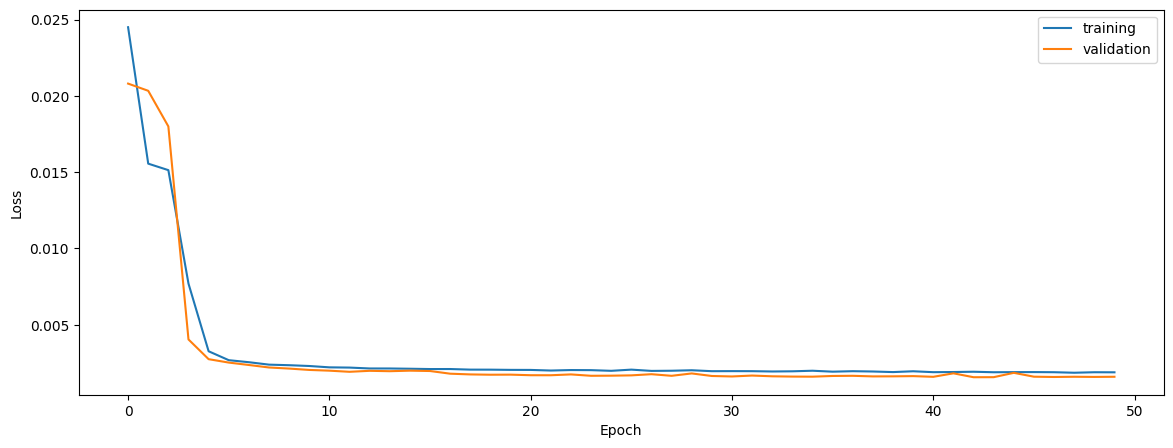

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.938624304467586
0.9617352481172925
0.9453670690926275


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.938624304467586
0.9617352481172925
0.9453670690926275


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9320183712602412
0.9552323463185691
0.941917342022978


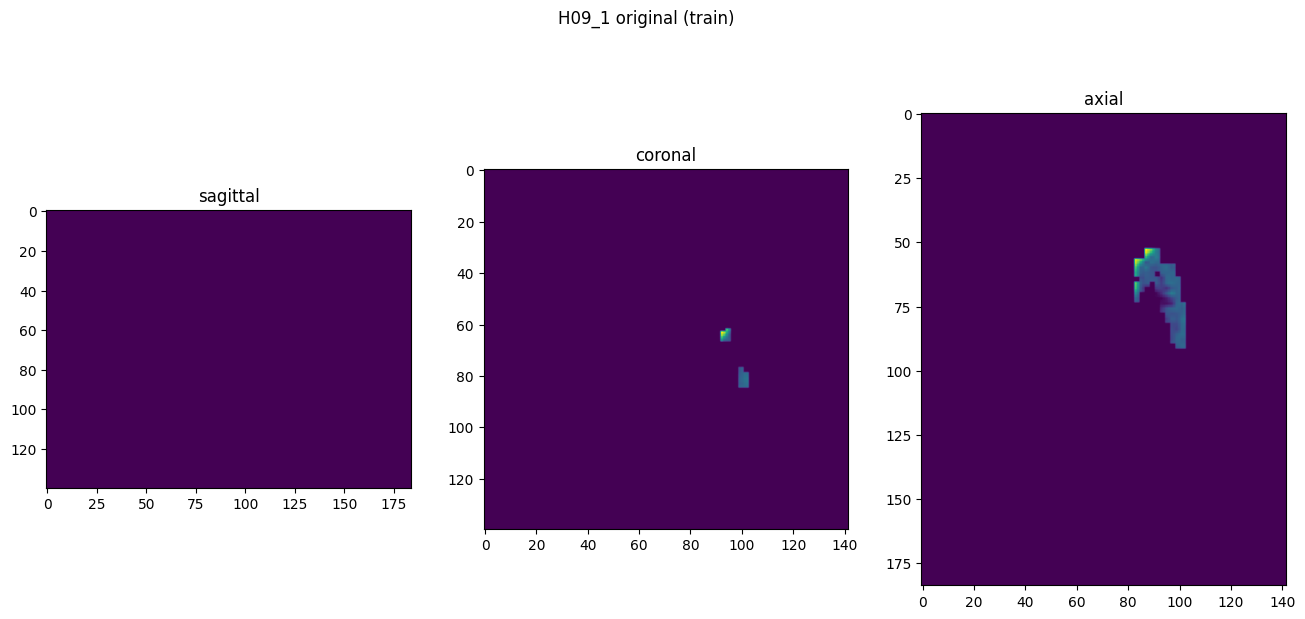

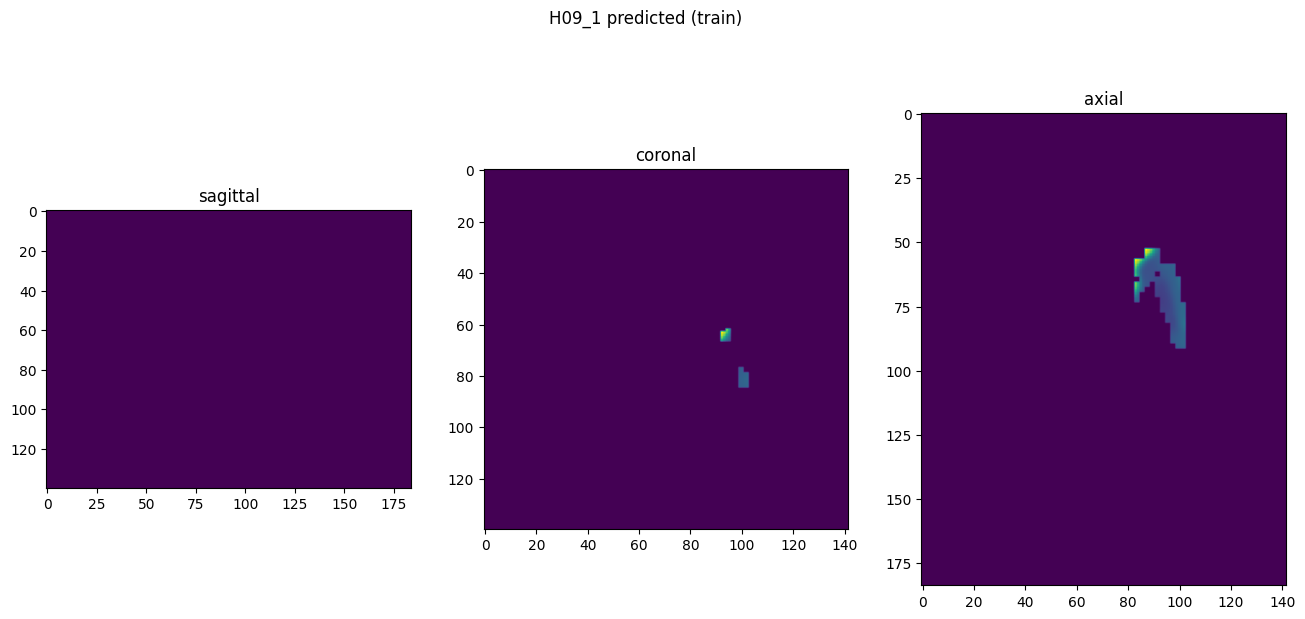

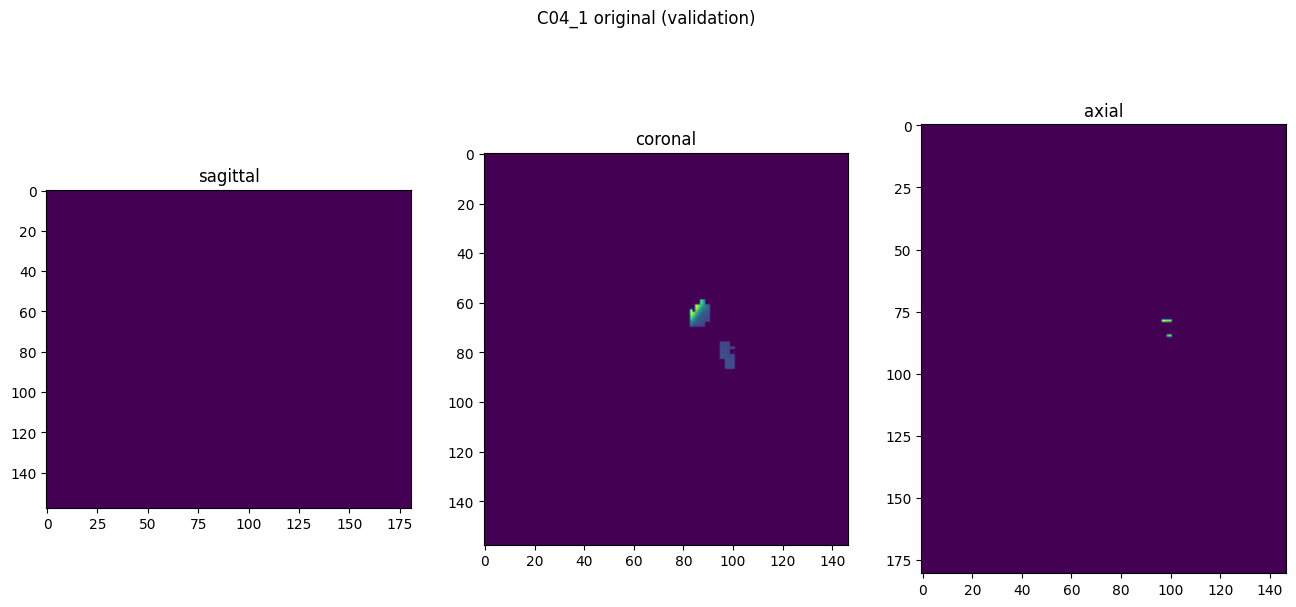

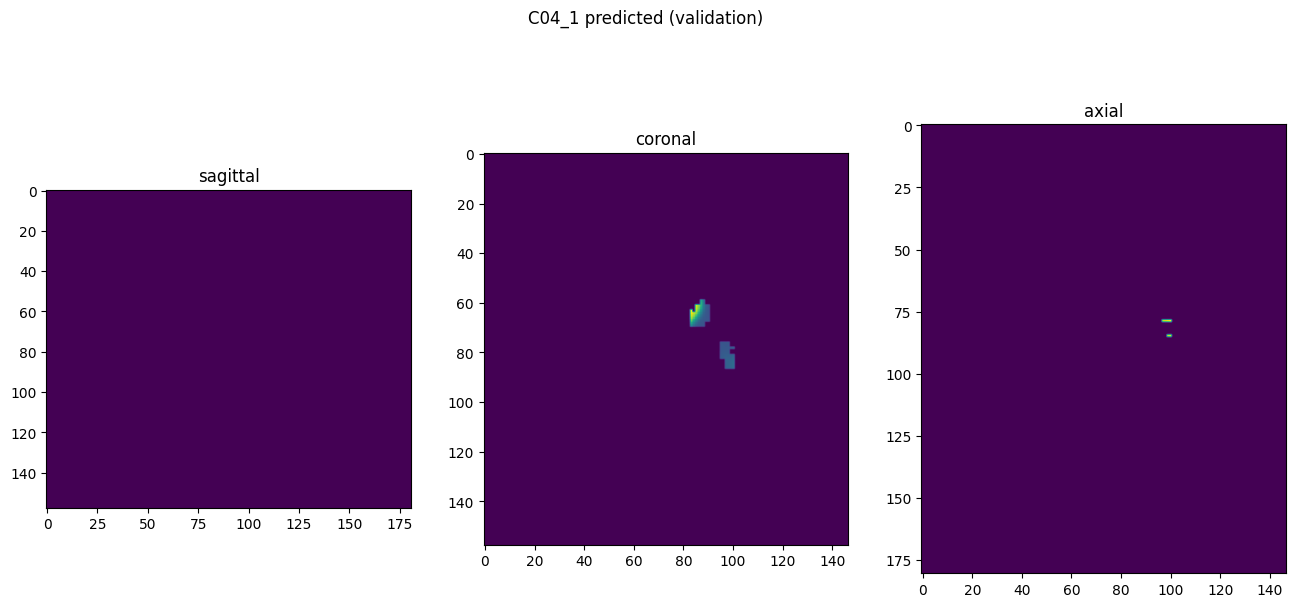

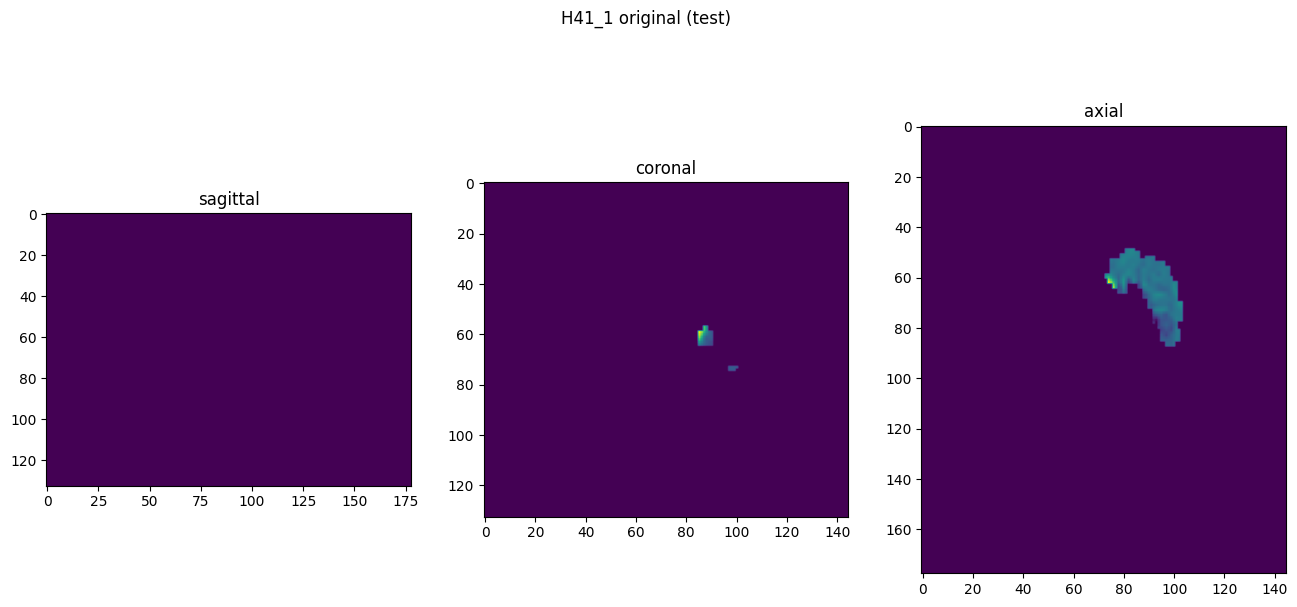

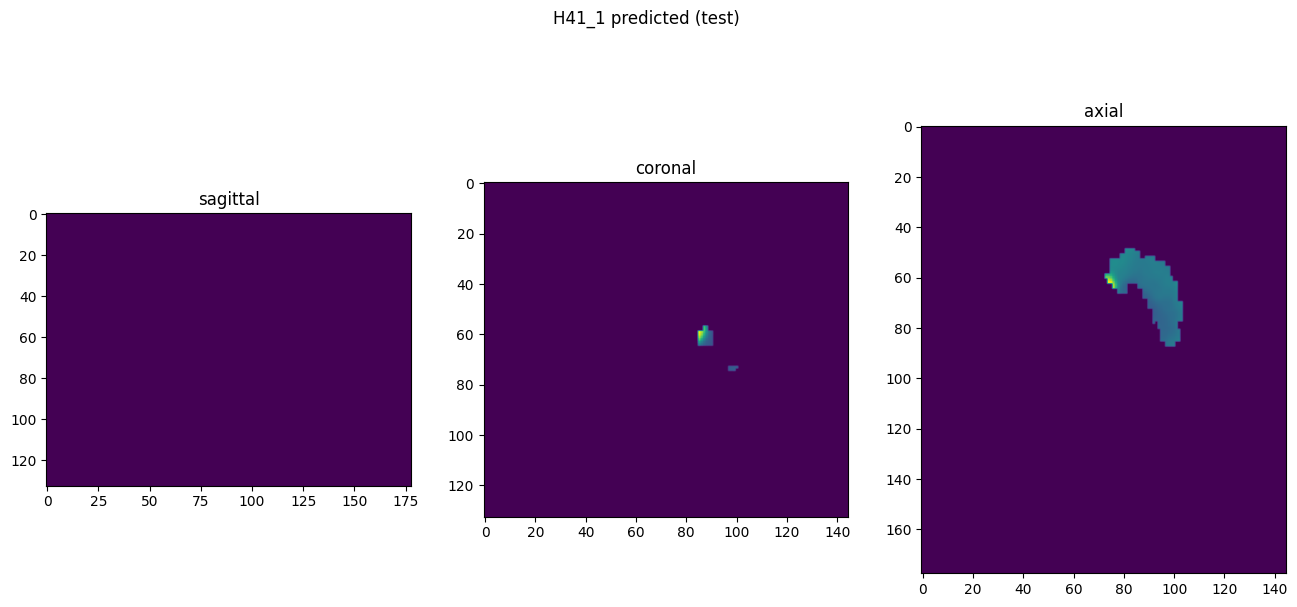

In [10]:
showResults(model, gen, threshold=None, background=False)